In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import _init_paths

import os
import cv2

from opts import opts
#from detectors.detector_factory import detector_factory

image_ext = ['jpg', 'jpeg', 'png', 'webp']
video_ext = ['mp4', 'mov', 'avi', 'mkv']
time_stats = ['tot', 'load', 'pre', 'net', 'dec', 'post', 'merge']


In [2]:
opt = opts().init(args=[])
opt

Fix size testing.
training chunk_sizes: [32]
The output will be saved to  /data/mry/code/CenterNet/src/lib/../../exp/gridneighbordet/gridneighbordet-test-inference
heads {'hm': 400, 'wh': 10, 'reg': 10}


Namespace(K=20, aggr_weight=0.0, agnostic_ex=False, arch='hourglass', aug_ddd=0.5, aug_rot=0, batch_size=32, cat_spec_wh=False, center_thresh=0.1, chunk_sizes=[32], data_dir='/data/mry/DataSet/', dataset='coco', debug=0, debug_dir='/data/mry/code/CenterNet/src/lib/../../exp/gridneighbordet/gridneighbordet-test-inference/debug', debugger_theme='white', demo='/data/mry/DataSet/COCO/val2014/COCO_val2014_000000017882.jpg', dense_hp=False, dense_wh=False, dep_weight=1, det_output_path='', dim_weight=1, down_ratio=4, eval_oracle_dep=False, eval_oracle_hm=False, eval_oracle_hmhp=False, eval_oracle_hp_offset=False, eval_oracle_kps=False, eval_oracle_offset=False, eval_oracle_wh=False, exp_dir='/data/mry/code/CenterNet/src/lib/../../exp/gridneighbordet', exp_id='gridneighbordet-test-inference', fix_res=True, flip=0, flip_test=False, gpus=[0], gpus_str='0', head_conv=64, heads={'hm': 400, 'wh': 10, 'reg': 10}, hide_data_time=False, hm_hp=True, hm_hp_weight=1, hm_weight=1, hp_weight=1, input_h=51

In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import torchvision.models as models
import torch
import torch.nn as nn
import os

from models.networks.msra_resnet import get_pose_net
from models.networks.dlav0 import get_pose_net as get_dlav0
from models.networks.pose_dla_dcn import get_pose_net as get_dla_dcn
from models.networks.resnet_dcn import get_pose_net as get_pose_net_dcn
from models.networks.large_hourglass import get_large_hourglass_net

_model_factory = {
  'res': get_pose_net, # default Resnet with deconv
  'dlav0': get_dlav0, # default DLAup
  'dla': get_dla_dcn,
  'resdcn': get_pose_net_dcn,
  'hourglass': get_large_hourglass_net,
}

def create_model(arch, heads, head_conv):
  num_layers = int(arch[arch.find('_') + 1:]) if '_' in arch else 0
  arch = arch[:arch.find('_')] if '_' in arch else arch
  get_model = _model_factory[arch]
  model = get_model(num_layers=num_layers, heads=heads, head_conv=head_conv)
  return model

def load_model(model, model_path, optimizer=None, resume=False, 
               lr=None, lr_step=None):
  start_epoch = 0
  checkpoint = torch.load(model_path, map_location=lambda storage, loc: storage)
  print('loaded {}, epoch {}'.format(model_path, checkpoint['epoch']))
  state_dict_ = checkpoint['state_dict']
  state_dict = {}
  
  # convert data_parallal to model
  for k in state_dict_:
    if k.startswith('module') and not k.startswith('module_list'):
      state_dict[k[7:]] = state_dict_[k]
    else:
      state_dict[k] = state_dict_[k]
  model_state_dict = model.state_dict()

  # check loaded parameters and created model parameters
  msg = 'If you see this, your model does not fully load the ' + \
        'pre-trained weight. Please make sure ' + \
        'you have correctly specified --arch xxx ' + \
        'or set the correct --num_classes for your own dataset.'
  for k in state_dict:
    if k in model_state_dict:
      if state_dict[k].shape != model_state_dict[k].shape:
        print('Skip loading parameter {}, required shape{}, '\
              'loaded shape{}. {}'.format(
          k, model_state_dict[k].shape, state_dict[k].shape, msg))
        state_dict[k] = model_state_dict[k]
    else:
      print('Drop parameter {}.'.format(k) + msg)
  for k in model_state_dict:
    if not (k in state_dict):
      print('No param {}.'.format(k) + msg)
      state_dict[k] = model_state_dict[k]
  model.load_state_dict(state_dict, strict=False)

  # resume optimizer parameters
  if optimizer is not None and resume:
    if 'optimizer' in checkpoint:
      optimizer.load_state_dict(checkpoint['optimizer'])
      start_epoch = checkpoint['epoch']
      start_lr = lr
      for step in lr_step:
        if start_epoch >= step:
          start_lr *= 0.1
      for param_group in optimizer.param_groups:
        param_group['lr'] = start_lr
      print('Resumed optimizer with start lr', start_lr)
    else:
      print('No optimizer parameters in checkpoint.')
  if optimizer is not None:
    return model, optimizer, start_epoch
  else:
    return model

In [4]:
# ------------------------------------------------------------------------------
# Copyright (c) Microsoft
# Licensed under the MIT License.
# Written by Bin Xiao (Bin.Xiao@microsoft.com)
# Modified by Xingyi Zhou
# ------------------------------------------------------------------------------

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import cv2
import random

def flip(img):
  return img[:, :, ::-1].copy()  

def transform_preds(coords, center, scale, output_size):
    target_coords = np.zeros(coords.shape)
    trans = get_affine_transform(center, scale, 0, output_size, inv=1)
    for p in range(coords.shape[0]):
        target_coords[p, 0:2] = affine_transform(coords[p, 0:2], trans)
    return target_coords


def get_affine_transform(center,
                         scale,
                         rot,
                         output_size,
                         shift=np.array([0, 0], dtype=np.float32),
                         inv=0):
    if not isinstance(scale, np.ndarray) and not isinstance(scale, list):
        scale = np.array([scale, scale], dtype=np.float32)

    scale_tmp = scale
    src_w = scale_tmp[0]
    dst_w = output_size[0]
    dst_h = output_size[1]

    rot_rad = np.pi * rot / 180
    src_dir = get_dir([0, src_w * -0.5], rot_rad)
    dst_dir = np.array([0, dst_w * -0.5], np.float32)

    src = np.zeros((3, 2), dtype=np.float32)
    dst = np.zeros((3, 2), dtype=np.float32)
    src[0, :] = center + scale_tmp * shift
    src[1, :] = center + src_dir + scale_tmp * shift
    dst[0, :] = [dst_w * 0.5, dst_h * 0.5]
    dst[1, :] = np.array([dst_w * 0.5, dst_h * 0.5], np.float32) + dst_dir

    src[2:, :] = get_3rd_point(src[0, :], src[1, :])
    dst[2:, :] = get_3rd_point(dst[0, :], dst[1, :])

    if inv:
        trans = cv2.getAffineTransform(np.float32(dst), np.float32(src))
    else:
        trans = cv2.getAffineTransform(np.float32(src), np.float32(dst))

    return trans


def affine_transform(pt, t):
    new_pt = np.array([pt[0], pt[1], 1.], dtype=np.float32).T
    new_pt = np.dot(t, new_pt)
    return new_pt[:2]


def get_3rd_point(a, b):
    direct = a - b
    return b + np.array([-direct[1], direct[0]], dtype=np.float32)


def get_dir(src_point, rot_rad):
    sn, cs = np.sin(rot_rad), np.cos(rot_rad)

    src_result = [0, 0]
    src_result[0] = src_point[0] * cs - src_point[1] * sn
    src_result[1] = src_point[0] * sn + src_point[1] * cs

    return src_result


def crop(img, center, scale, output_size, rot=0):
    trans = get_affine_transform(center, scale, rot, output_size)

    dst_img = cv2.warpAffine(img,
                             trans,
                             (int(output_size[0]), int(output_size[1])),
                             flags=cv2.INTER_LINEAR)

    return dst_img


def gaussian_radius(det_size, min_overlap=0.7):
  height, width = det_size

  a1  = 1
  b1  = (height + width)
  c1  = width * height * (1 - min_overlap) / (1 + min_overlap)
  sq1 = np.sqrt(b1 ** 2 - 4 * a1 * c1)
  r1  = (b1 + sq1) / 2

  a2  = 4
  b2  = 2 * (height + width)
  c2  = (1 - min_overlap) * width * height
  sq2 = np.sqrt(b2 ** 2 - 4 * a2 * c2)
  r2  = (b2 + sq2) / 2

  a3  = 4 * min_overlap
  b3  = -2 * min_overlap * (height + width)
  c3  = (min_overlap - 1) * width * height
  sq3 = np.sqrt(b3 ** 2 - 4 * a3 * c3)
  r3  = (b3 + sq3) / 2
  return min(r1, r2, r3)


def gaussian2D(shape, sigma=1):
    m, n = [(ss - 1.) / 2. for ss in shape]
    y, x = np.ogrid[-m:m+1,-n:n+1]

    h = np.exp(-(x * x + y * y) / (2 * sigma * sigma))
    h[h < np.finfo(h.dtype).eps * h.max()] = 0
    return h

def draw_umich_gaussian(heatmap, center, radius, k=1):
  diameter = 2 * radius + 1
  gaussian = gaussian2D((diameter, diameter), sigma=diameter / 6)
  
  x, y = int(center[0]), int(center[1])

  height, width = heatmap.shape[0:2]
    
  left, right = min(x, radius), min(width - x, radius + 1)
  top, bottom = min(y, radius), min(height - y, radius + 1)

  masked_heatmap  = heatmap[y - top:y + bottom, x - left:x + right]
  masked_gaussian = gaussian[radius - top:radius + bottom, radius - left:radius + right]
  if min(masked_gaussian.shape) > 0 and min(masked_heatmap.shape) > 0: # TODO debug
    np.maximum(masked_heatmap, masked_gaussian * k, out=masked_heatmap)
  return heatmap

def draw_dense_reg(regmap, heatmap, center, value, radius, is_offset=False):
  diameter = 2 * radius + 1
  gaussian = gaussian2D((diameter, diameter), sigma=diameter / 6)
  value = np.array(value, dtype=np.float32).reshape(-1, 1, 1)
  dim = value.shape[0]
  reg = np.ones((dim, diameter*2+1, diameter*2+1), dtype=np.float32) * value
  if is_offset and dim == 2:
    delta = np.arange(diameter*2+1) - radius
    reg[0] = reg[0] - delta.reshape(1, -1)
    reg[1] = reg[1] - delta.reshape(-1, 1)
  
  x, y = int(center[0]), int(center[1])

  height, width = heatmap.shape[0:2]
    
  left, right = min(x, radius), min(width - x, radius + 1)
  top, bottom = min(y, radius), min(height - y, radius + 1)

  masked_heatmap = heatmap[y - top:y + bottom, x - left:x + right]
  masked_regmap = regmap[:, y - top:y + bottom, x - left:x + right]
  masked_gaussian = gaussian[radius - top:radius + bottom,
                             radius - left:radius + right]
  masked_reg = reg[:, radius - top:radius + bottom,
                      radius - left:radius + right]
  if min(masked_gaussian.shape) > 0 and min(masked_heatmap.shape) > 0: # TODO debug
    idx = (masked_gaussian >= masked_heatmap).reshape(
      1, masked_gaussian.shape[0], masked_gaussian.shape[1])
    masked_regmap = (1-idx) * masked_regmap + idx * masked_reg
  regmap[:, y - top:y + bottom, x - left:x + right] = masked_regmap
  return regmap


def draw_msra_gaussian(heatmap, center, sigma):
  tmp_size = sigma * 3
  mu_x = int(center[0] + 0.5)
  mu_y = int(center[1] + 0.5)
  w, h = heatmap.shape[0], heatmap.shape[1]
  ul = [int(mu_x - tmp_size), int(mu_y - tmp_size)]
  br = [int(mu_x + tmp_size + 1), int(mu_y + tmp_size + 1)]
  if ul[0] >= h or ul[1] >= w or br[0] < 0 or br[1] < 0:
    return heatmap
  size = 2 * tmp_size + 1
  x = np.arange(0, size, 1, np.float32)
  y = x[:, np.newaxis]
  x0 = y0 = size // 2
  g = np.exp(- ((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2))
  g_x = max(0, -ul[0]), min(br[0], h) - ul[0]
  g_y = max(0, -ul[1]), min(br[1], w) - ul[1]
  img_x = max(0, ul[0]), min(br[0], h)
  img_y = max(0, ul[1]), min(br[1], w)
  heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]] = np.maximum(
    heatmap[img_y[0]:img_y[1], img_x[0]:img_x[1]],
    g[g_y[0]:g_y[1], g_x[0]:g_x[1]])
  return heatmap

def grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def lighting_(data_rng, image, alphastd, eigval, eigvec):
    alpha = data_rng.normal(scale=alphastd, size=(3, ))
    image += np.dot(eigvec, eigval * alpha)

def blend_(alpha, image1, image2):
    image1 *= alpha
    image2 *= (1 - alpha)
    image1 += image2

def saturation_(data_rng, image, gs, gs_mean, var):
    alpha = 1. + data_rng.uniform(low=-var, high=var)
    blend_(alpha, image, gs[:, :, None])

def brightness_(data_rng, image, gs, gs_mean, var):
    alpha = 1. + data_rng.uniform(low=-var, high=var)
    image *= alpha

def contrast_(data_rng, image, gs, gs_mean, var):
    alpha = 1. + data_rng.uniform(low=-var, high=var)
    blend_(alpha, image, gs_mean)

def color_aug(data_rng, image, eig_val, eig_vec):
    functions = [brightness_, contrast_, saturation_]
    random.shuffle(functions)

    gs = grayscale(image)
    gs_mean = gs.mean()
    for f in functions:
        f(data_rng, image, gs, gs_mean, 0.4)
    lighting_(data_rng, image, 0.1, eig_val, eig_vec)


In [5]:
import cv2
import numpy as np
from progress.bar import Bar
import time
import torch
import pdb

class BaseDetector(object):
  def __init__(self, opt):
    if opt.gpus[0] >= 0:
      opt.device = torch.device('cuda')
    else:
      opt.device = torch.device('cpu')
    
    print('Creating model...')
    self.model = create_model(opt.arch, opt.heads, opt.head_conv)
    self.model = load_model(self.model, opt.load_model)
    self.model = self.model.to(opt.device)
    self.model.eval()

    self.mean = np.array(opt.mean, dtype=np.float32).reshape(1, 1, 3)
    self.std = np.array(opt.std, dtype=np.float32).reshape(1, 1, 3)
    self.max_per_image = 100
    self.num_classes = opt.num_classes
    self.scales = opt.test_scales
    self.opt = opt
    self.pause = True

  def pre_process(self, image, scale, meta=None):
    height, width = image.shape[0:2]
    new_height = int(height * scale)
    new_width  = int(width * scale)
    if self.opt.fix_res:
      inp_height, inp_width = self.opt.input_h, self.opt.input_w
      c = np.array([new_width / 2., new_height / 2.], dtype=np.float32)
      s = max(height, width) * 1.0
    else:
      inp_height = (new_height | self.opt.pad) + 1
      inp_width = (new_width | self.opt.pad) + 1
      c = np.array([new_width // 2, new_height // 2], dtype=np.float32)
      s = np.array([inp_width, inp_height], dtype=np.float32)

    trans_input = get_affine_transform(c, s, 0, [inp_width, inp_height])
    resized_image = cv2.resize(image, (new_width, new_height))
    inp_image = cv2.warpAffine(
      resized_image, trans_input, (inp_width, inp_height),
      flags=cv2.INTER_LINEAR)
    inp_image = ((inp_image / 255. - self.mean) / self.std).astype(np.float32)

    images = inp_image.transpose(2, 0, 1).reshape(1, 3, inp_height, inp_width)
    if self.opt.flip_test:
      images = np.concatenate((images, images[:, :, :, ::-1]), axis=0)
    images = torch.from_numpy(images)
    meta = {'c': c, 's': s, 
            'out_height': inp_height // self.opt.down_ratio, 
            'out_width': inp_width // self.opt.down_ratio}
    return images, meta

  def process(self, images, return_time=False):
    raise NotImplementedError

  def post_process(self, dets, meta, scale=1):
    raise NotImplementedError

  def merge_outputs(self, detections):
    raise NotImplementedError

  def debug(self, debugger, images, dets, output, scale=1):
    raise NotImplementedError

  def show_results(self, debugger, image, results):
   raise NotImplementedError

  def save_results_only(self, debugger, image, results, image_name):
   raise NotImplementedError

  #def save_person_only(self, debugger, image, results, image_name):
  # raise NotImplementedError


  def run(self, image_or_path_or_tensor, meta=None):
    pdb.set_trace()
    load_time, pre_time, net_time, dec_time, post_time = 0, 0, 0, 0, 0
    merge_time, tot_time = 0, 0
    image_name = None
    debugger = Debugger(dataset=self.opt.dataset, ipynb=(self.opt.debug==3),
                        theme=self.opt.debugger_theme)
    start_time = time.time()
    pre_processed = False
    if isinstance(image_or_path_or_tensor, np.ndarray):
      image = image_or_path_or_tensor
    elif type(image_or_path_or_tensor) == type (''): 
      image = cv2.imread(image_or_path_or_tensor)
      import os
      image_name = os.path.basename(image_or_path_or_tensor)
    else:
      image = image_or_path_or_tensor['image'][0].numpy()
      pre_processed_images = image_or_path_or_tensor
      pre_processed = True
    
    loaded_time = time.time()
    load_time += (loaded_time - start_time)
    
    detections = []
    for scale in self.scales:
      scale_start_time = time.time()
      if not pre_processed:
        images, meta = self.pre_process(image, scale, meta)
      else:
        # import pdb; pdb.set_trace()
        images = pre_processed_images['images'][scale][0]
        meta = pre_processed_images['meta'][scale]
        meta = {k: v.numpy()[0] for k, v in meta.items()}
      images = images.to(self.opt.device)
      torch.cuda.synchronize()
      pre_process_time = time.time()
      pre_time += pre_process_time - scale_start_time
      
      output, dets, forward_time = self.process(images, return_time=True)
      print(image_name)
      print(dets)

      torch.cuda.synchronize()
      net_time += forward_time - pre_process_time
      decode_time = time.time()
      dec_time += decode_time - forward_time
      
      if self.opt.debug >= 2:
        self.debug(debugger, images, dets, output, scale)

      
      dets = self.post_process(dets, meta, scale)
      #print(dets)
      torch.cuda.synchronize()
      post_process_time = time.time()
      post_time += post_process_time - decode_time

      detections.append(dets)
    
    results = self.merge_outputs(detections)
    torch.cuda.synchronize()
    end_time = time.time()
    merge_time += end_time - post_process_time
    tot_time += end_time - start_time

    if self.opt.debug >= 1:
      if image_name is not None:
        self.show_results(debugger, image, results)
        #self.save_person_only(debugger, image, results, image_name)

    if self.opt.debug == 0:
      if image_name is not None:
        self.save_results_only(debugger, image, results, image_name)

    return {'results': results, 'tot': tot_time, 'load': load_time,
            'pre': pre_time, 'net': net_time, 'dec': dec_time,
            'post': post_time, 'merge': merge_time, 'image_name': image_name}

In [6]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import torch
import torch.nn as nn

def _sigmoid(x):
  y = torch.clamp(x.sigmoid_(), min=1e-4, max=1-1e-4)
  return y

def _gather_feat(feat, ind, mask=None):
    dim  = feat.size(2)
    ind  = ind.unsqueeze(2).expand(ind.size(0), ind.size(1), dim)
    feat = feat.gather(1, ind)
    if mask is not None:
        mask = mask.unsqueeze(2).expand_as(feat)
        feat = feat[mask]
        feat = feat.view(-1, dim)
    return feat

def _gather_feat_gridneighbor(feat, ind, mask=None):
    dim  = feat.size(2)
    ind  = ind.unsqueeze(3).expand(ind.size(0), ind.size(1),ind.size(2), dim//ind.size(2)).contiguous().view(ind.size(0), ind.size(1), -1)
    feat = feat.gather(1, ind)
    if mask is not None:
        mask = mask.unsqueeze(2).expand_as(feat)
        feat = feat[mask]
        feat = feat.view(-1, dim)
    return feat

def _tranpose_and_gather_feat(feat, ind):
    feat = feat.permute(0, 2, 3, 1).contiguous()
    feat = feat.view(feat.size(0), -1, feat.size(3))
    feat = _gather_feat(feat, ind)
    return feat

def _tranpose_and_gather_feat_gridneighbor(feat, ind):
    feat = feat.permute(0, 2, 3, 1).contiguous()
    feat = feat.view(feat.size(0), -1, feat.size(3))
    feat = _gather_feat_gridneighbor(feat, ind)
    return feat

def flip_tensor(x):
    return torch.flip(x, [3])
    # tmp = x.detach().cpu().numpy()[..., ::-1].copy()
    # return torch.from_numpy(tmp).to(x.device)

def flip_lr(x, flip_idx):
  tmp = x.detach().cpu().numpy()[..., ::-1].copy()
  shape = tmp.shape
  for e in flip_idx:
    tmp[:, e[0], ...], tmp[:, e[1], ...] = \
      tmp[:, e[1], ...].copy(), tmp[:, e[0], ...].copy()
  return torch.from_numpy(tmp.reshape(shape)).to(x.device)

def flip_lr_off(x, flip_idx):
  tmp = x.detach().cpu().numpy()[..., ::-1].copy()
  shape = tmp.shape
  tmp = tmp.reshape(tmp.shape[0], 17, 2, 
                    tmp.shape[2], tmp.shape[3])
  tmp[:, :, 0, :, :] *= -1
  for e in flip_idx:
    tmp[:, e[0], ...], tmp[:, e[1], ...] = \
      tmp[:, e[1], ...].copy(), tmp[:, e[0], ...].copy()
  return torch.from_numpy(tmp.reshape(shape)).to(x.device)

def landmark_flip_lr_off(x, flip_idx):
  tmp = x.detach().cpu().numpy()[..., ::-1].copy()
  shape = tmp.shape
  tmp = tmp.reshape(tmp.shape[0], 68, 2,
                    tmp.shape[2], tmp.shape[3])
  tmp[:, :, 0, :, :] *= -1
  for e in flip_idx:
    tmp[:, e[0], ...], tmp[:, e[1], ...] = \
      tmp[:, e[1], ...].copy(), tmp[:, e[0], ...].copy()
  return torch.from_numpy(tmp.reshape(shape)).to(x.device)

def clothlandmark_flip_lr_off(x, flip_idx):
  tmp = x.detach().cpu().numpy()[..., ::-1].copy()
  shape = tmp.shape
  tmp = tmp.reshape(tmp.shape[0], 294, 2,
                    tmp.shape[2], tmp.shape[3])
  tmp[:, :, 0, :, :] *= -1
  for e in flip_idx:
    tmp[:, e[0], ...], tmp[:, e[1], ...] = \
      tmp[:, e[1], ...].copy(), tmp[:, e[0], ...].copy()
  return torch.from_numpy(tmp.reshape(shape)).to(x.device)

In [7]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import torch
import torch.nn as nn

def _nms(heat, kernel=3):
    pad = (kernel - 1) // 2

    hmax = nn.functional.max_pool2d(
        heat, (kernel, kernel), stride=1, padding=pad)
    keep = (hmax == heat).float()
    return heat * keep

def _left_aggregate(heat):
    '''
        heat: batchsize x channels x h x w
    '''
    shape = heat.shape 
    heat = heat.reshape(-1, heat.shape[3])
    heat = heat.transpose(1, 0).contiguous()
    ret = heat.clone()
    for i in range(1, heat.shape[0]):
        inds = (heat[i] >= heat[i - 1])
        ret[i] += ret[i - 1] * inds.float()
    return (ret - heat).transpose(1, 0).reshape(shape) 

def _right_aggregate(heat):
    '''
        heat: batchsize x channels x h x w
    '''
    shape = heat.shape 
    heat = heat.reshape(-1, heat.shape[3])
    heat = heat.transpose(1, 0).contiguous()
    ret = heat.clone()
    for i in range(heat.shape[0] - 2, -1, -1):
        inds = (heat[i] >= heat[i +1])
        ret[i] += ret[i + 1] * inds.float()
    return (ret - heat).transpose(1, 0).reshape(shape) 

def _top_aggregate(heat):
    '''
        heat: batchsize x channels x h x w
    '''
    heat = heat.transpose(3, 2) 
    shape = heat.shape
    heat = heat.reshape(-1, heat.shape[3])
    heat = heat.transpose(1, 0).contiguous()
    ret = heat.clone()
    for i in range(1, heat.shape[0]):
        inds = (heat[i] >= heat[i - 1])
        ret[i] += ret[i - 1] * inds.float()
    return (ret - heat).transpose(1, 0).reshape(shape).transpose(3, 2)

def _bottom_aggregate(heat):
    '''
        heat: batchsize x channels x h x w
    '''
    heat = heat.transpose(3, 2) 
    shape = heat.shape
    heat = heat.reshape(-1, heat.shape[3])
    heat = heat.transpose(1, 0).contiguous()
    ret = heat.clone()
    for i in range(heat.shape[0] - 2, -1, -1):
        inds = (heat[i] >= heat[i + 1])
        ret[i] += ret[i + 1] * inds.float()
    return (ret - heat).transpose(1, 0).reshape(shape).transpose(3, 2)

def _h_aggregate(heat, aggr_weight=0.1):
    return aggr_weight * _left_aggregate(heat) + \
           aggr_weight * _right_aggregate(heat) + heat

def _v_aggregate(heat, aggr_weight=0.1):
    return aggr_weight * _top_aggregate(heat) + \
           aggr_weight * _bottom_aggregate(heat) + heat

'''
# Slow for large number of categories
def _topk(scores, K=40):
    batch, cat, height, width = scores.size()
    topk_scores, topk_inds = torch.topk(scores.view(batch, -1), K)

    topk_clses = (topk_inds / (height * width)).int()

    topk_inds = topk_inds % (height * width)
    topk_ys   = (topk_inds / width).int().float()
    topk_xs   = (topk_inds % width).int().float()
    return topk_scores, topk_inds, topk_clses, topk_ys, topk_xs
'''
def _topk_channel(scores, K=40):
      batch, cat, height, width = scores.size()
      
      topk_scores, topk_inds = torch.topk(scores.view(batch, cat, -1), K)

      topk_inds = topk_inds % (height * width)
      topk_ys   = (topk_inds / width).int().float()
      topk_xs   = (topk_inds % width).int().float()

      return topk_scores, topk_inds, topk_ys, topk_xs

def _topk(scores, K=40):
    batch, cat, height, width = scores.size()
      
    topk_scores, topk_inds = torch.topk(scores.view(batch, cat, -1), K)

    topk_inds = topk_inds % (height * width)
    topk_ys   = (topk_inds / width).int().float()
    topk_xs   = (topk_inds % width).int().float()
      
    topk_score, topk_ind = torch.topk(topk_scores.view(batch, -1), K)
    topk_clses = (topk_ind / K).int()
    topk_inds = _gather_feat(
        topk_inds.view(batch, -1, 1), topk_ind).view(batch, K)
    topk_ys = _gather_feat(topk_ys.view(batch, -1, 1), topk_ind).view(batch, K)
    topk_xs = _gather_feat(topk_xs.view(batch, -1, 1), topk_ind).view(batch, K)

    return topk_score, topk_inds, topk_clses, topk_ys, topk_xs

def _topk_gridneighbor(scores, main_points_num, K=40):
    batch, allchannels, height, width = scores.size()
    cat = allchannels//main_points_num 
    
    topk_scores, topk_inds = torch.topk(scores.view(1, allchannels, -1), K)

    topk_scores = topk_scores.contiguous().view(1,cat, main_points_num, -1)

    topk_scores = topk_scores.permute(0,2,1,3).contiguous().view(1,main_points_num,-1)


    topk_inds = topk_inds.contiguous().view(1,cat, main_points_num, -1)

    topk_inds = topk_inds.permute(0,2,1,3).contiguous().view(1,main_points_num,-1)
    
    topk_inds = topk_inds % (height * width)
    topk_ys   = (topk_inds / width).int().float()
    topk_xs   = (topk_inds % width).int().float()
    
    topk_score, topk_ind = torch.topk(topk_scores, K)
    
    topk_clses = (topk_ind / K).int().permute(0, 2,1)
    
    topk_inds = topk_inds.permute(0, 2,1)
    topk_ind = topk_ind.permute(0,2,1)
    topk_inds = topk_inds.gather(1, topk_ind)
    topk_ys =  topk_ys.permute(0, 2,1)
    topk_xs =  topk_xs.permute(0, 2,1)
    topk_ys = topk_ys.gather(1, topk_ind)
    topk_xs = topk_xs.gather(1, topk_ind)
    #print('topk_ys',topk_ys)
    #print('topk_xs',topk_xs)
    #print('topk_score',topk_score)
    #print('topk_inds',topk_inds)
    #print('topk_clses',topk_clses)
    return topk_score.permute(0,2,1), topk_inds, topk_clses, topk_ys, topk_xs
    
    



def agnex_ct_decode(
    t_heat, l_heat, b_heat, r_heat, ct_heat, 
    t_regr=None, l_regr=None, b_regr=None, r_regr=None, 
    K=40, scores_thresh=0.1, center_thresh=0.1, aggr_weight=0.0, num_dets=1000
):
    batch, cat, height, width = t_heat.size()

    '''
    t_heat  = torch.sigmoid(t_heat)
    l_heat  = torch.sigmoid(l_heat)
    b_heat  = torch.sigmoid(b_heat)
    r_heat  = torch.sigmoid(r_heat)
    ct_heat = torch.sigmoid(ct_heat)
    '''
    if aggr_weight > 0: 
      t_heat = _h_aggregate(t_heat, aggr_weight=aggr_weight)
      l_heat = _v_aggregate(l_heat, aggr_weight=aggr_weight)
      b_heat = _h_aggregate(b_heat, aggr_weight=aggr_weight)
      r_heat = _v_aggregate(r_heat, aggr_weight=aggr_weight)
      
    # perform nms on heatmaps
    t_heat = _nms(t_heat)
    l_heat = _nms(l_heat)
    b_heat = _nms(b_heat)
    r_heat = _nms(r_heat)
      
      
    t_heat[t_heat > 1] = 1
    l_heat[l_heat > 1] = 1
    b_heat[b_heat > 1] = 1
    r_heat[r_heat > 1] = 1

    t_scores, t_inds, _, t_ys, t_xs = _topk(t_heat, K=K)
    l_scores, l_inds, _, l_ys, l_xs = _topk(l_heat, K=K)
    b_scores, b_inds, _, b_ys, b_xs = _topk(b_heat, K=K)
    r_scores, r_inds, _, r_ys, r_xs = _topk(r_heat, K=K)
      
    ct_heat_agn, ct_clses = torch.max(ct_heat, dim=1, keepdim=True)
      
    # import pdb; pdb.set_trace()

    t_ys = t_ys.view(batch, K, 1, 1, 1).expand(batch, K, K, K, K)
    t_xs = t_xs.view(batch, K, 1, 1, 1).expand(batch, K, K, K, K)
    l_ys = l_ys.view(batch, 1, K, 1, 1).expand(batch, K, K, K, K)
    l_xs = l_xs.view(batch, 1, K, 1, 1).expand(batch, K, K, K, K)
    b_ys = b_ys.view(batch, 1, 1, K, 1).expand(batch, K, K, K, K)
    b_xs = b_xs.view(batch, 1, 1, K, 1).expand(batch, K, K, K, K)
    r_ys = r_ys.view(batch, 1, 1, 1, K).expand(batch, K, K, K, K)
    r_xs = r_xs.view(batch, 1, 1, 1, K).expand(batch, K, K, K, K)

    box_ct_xs = ((l_xs + r_xs + 0.5) / 2).long()
    box_ct_ys = ((t_ys + b_ys + 0.5) / 2).long()

    ct_inds     = box_ct_ys * width + box_ct_xs
    ct_inds     = ct_inds.view(batch, -1)
    ct_heat_agn = ct_heat_agn.view(batch, -1, 1)
    ct_clses    = ct_clses.view(batch, -1, 1)
    ct_scores   = _gather_feat(ct_heat_agn, ct_inds)
    clses       = _gather_feat(ct_clses, ct_inds)

    t_scores = t_scores.view(batch, K, 1, 1, 1).expand(batch, K, K, K, K)
    l_scores = l_scores.view(batch, 1, K, 1, 1).expand(batch, K, K, K, K)
    b_scores = b_scores.view(batch, 1, 1, K, 1).expand(batch, K, K, K, K)
    r_scores = r_scores.view(batch, 1, 1, 1, K).expand(batch, K, K, K, K)
    ct_scores = ct_scores.view(batch, K, K, K, K)
    scores    = (t_scores + l_scores + b_scores + r_scores + 2 * ct_scores) / 6

    # reject boxes based on classes
    top_inds  = (t_ys > l_ys) + (t_ys > b_ys) + (t_ys > r_ys)
    top_inds = (top_inds > 0)
    left_inds  = (l_xs > t_xs) + (l_xs > b_xs) + (l_xs > r_xs)
    left_inds = (left_inds > 0)
    bottom_inds  = (b_ys < t_ys) + (b_ys < l_ys) + (b_ys < r_ys)
    bottom_inds = (bottom_inds > 0)
    right_inds  = (r_xs < t_xs) + (r_xs < l_xs) + (r_xs < b_xs)
    right_inds = (right_inds > 0)

    sc_inds = (t_scores < scores_thresh) + (l_scores < scores_thresh) + \
              (b_scores < scores_thresh) + (r_scores < scores_thresh) + \
              (ct_scores < center_thresh)
    sc_inds = (sc_inds > 0)

    scores = scores - sc_inds.float()
    scores = scores - top_inds.float()
    scores = scores - left_inds.float()
    scores = scores - bottom_inds.float()
    scores = scores - right_inds.float()

    scores = scores.view(batch, -1)
    scores, inds = torch.topk(scores, num_dets)
    scores = scores.unsqueeze(2)

    if t_regr is not None and l_regr is not None \
      and b_regr is not None and r_regr is not None:
        t_regr = _tranpose_and_gather_feat(t_regr, t_inds)
        t_regr = t_regr.view(batch, K, 1, 1, 1, 2)
        l_regr = _tranpose_and_gather_feat(l_regr, l_inds)
        l_regr = l_regr.view(batch, 1, K, 1, 1, 2)
        b_regr = _tranpose_and_gather_feat(b_regr, b_inds)
        b_regr = b_regr.view(batch, 1, 1, K, 1, 2)
        r_regr = _tranpose_and_gather_feat(r_regr, r_inds)
        r_regr = r_regr.view(batch, 1, 1, 1, K, 2)

        t_xs = t_xs + t_regr[..., 0]
        t_ys = t_ys + t_regr[..., 1]
        l_xs = l_xs + l_regr[..., 0]
        l_ys = l_ys + l_regr[..., 1]
        b_xs = b_xs + b_regr[..., 0]
        b_ys = b_ys + b_regr[..., 1]
        r_xs = r_xs + r_regr[..., 0]
        r_ys = r_ys + r_regr[..., 1]
    else:
        t_xs = t_xs + 0.5
        t_ys = t_ys + 0.5
        l_xs = l_xs + 0.5
        l_ys = l_ys + 0.5
        b_xs = b_xs + 0.5
        b_ys = b_ys + 0.5
        r_xs = r_xs + 0.5
        r_ys = r_ys + 0.5
      
    bboxes = torch.stack((l_xs, t_ys, r_xs, b_ys), dim=5)
    bboxes = bboxes.view(batch, -1, 4)
    bboxes = _gather_feat(bboxes, inds)

    clses  = clses.contiguous().view(batch, -1, 1)
    clses  = _gather_feat(clses, inds).float()

    t_xs = t_xs.contiguous().view(batch, -1, 1)
    t_xs = _gather_feat(t_xs, inds).float()
    t_ys = t_ys.contiguous().view(batch, -1, 1)
    t_ys = _gather_feat(t_ys, inds).float()
    l_xs = l_xs.contiguous().view(batch, -1, 1)
    l_xs = _gather_feat(l_xs, inds).float()
    l_ys = l_ys.contiguous().view(batch, -1, 1)
    l_ys = _gather_feat(l_ys, inds).float()
    b_xs = b_xs.contiguous().view(batch, -1, 1)
    b_xs = _gather_feat(b_xs, inds).float()
    b_ys = b_ys.contiguous().view(batch, -1, 1)
    b_ys = _gather_feat(b_ys, inds).float()
    r_xs = r_xs.contiguous().view(batch, -1, 1)
    r_xs = _gather_feat(r_xs, inds).float()
    r_ys = r_ys.contiguous().view(batch, -1, 1)
    r_ys = _gather_feat(r_ys, inds).float()


    detections = torch.cat([bboxes, scores, t_xs, t_ys, l_xs, l_ys, 
                            b_xs, b_ys, r_xs, r_ys, clses], dim=2)

    return detections

def exct_decode(
    t_heat, l_heat, b_heat, r_heat, ct_heat, 
    t_regr=None, l_regr=None, b_regr=None, r_regr=None, 
    K=40, scores_thresh=0.1, center_thresh=0.1, aggr_weight=0.0, num_dets=1000
):
    batch, cat, height, width = t_heat.size()
    '''
    t_heat  = torch.sigmoid(t_heat)
    l_heat  = torch.sigmoid(l_heat)
    b_heat  = torch.sigmoid(b_heat)
    r_heat  = torch.sigmoid(r_heat)
    ct_heat = torch.sigmoid(ct_heat)
    '''

    if aggr_weight > 0:   
      t_heat = _h_aggregate(t_heat, aggr_weight=aggr_weight)
      l_heat = _v_aggregate(l_heat, aggr_weight=aggr_weight)
      b_heat = _h_aggregate(b_heat, aggr_weight=aggr_weight)
      r_heat = _v_aggregate(r_heat, aggr_weight=aggr_weight)
      
    # perform nms on heatmaps
    t_heat = _nms(t_heat)
    l_heat = _nms(l_heat)
    b_heat = _nms(b_heat)
    r_heat = _nms(r_heat)
      
    t_heat[t_heat > 1] = 1
    l_heat[l_heat > 1] = 1
    b_heat[b_heat > 1] = 1
    r_heat[r_heat > 1] = 1

    t_scores, t_inds, t_clses, t_ys, t_xs = _topk(t_heat, K=K)
    l_scores, l_inds, l_clses, l_ys, l_xs = _topk(l_heat, K=K)
    b_scores, b_inds, b_clses, b_ys, b_xs = _topk(b_heat, K=K)
    r_scores, r_inds, r_clses, r_ys, r_xs = _topk(r_heat, K=K)

    t_ys = t_ys.view(batch, K, 1, 1, 1).expand(batch, K, K, K, K)
    t_xs = t_xs.view(batch, K, 1, 1, 1).expand(batch, K, K, K, K)
    l_ys = l_ys.view(batch, 1, K, 1, 1).expand(batch, K, K, K, K)
    l_xs = l_xs.view(batch, 1, K, 1, 1).expand(batch, K, K, K, K)
    b_ys = b_ys.view(batch, 1, 1, K, 1).expand(batch, K, K, K, K)
    b_xs = b_xs.view(batch, 1, 1, K, 1).expand(batch, K, K, K, K)
    r_ys = r_ys.view(batch, 1, 1, 1, K).expand(batch, K, K, K, K)
    r_xs = r_xs.view(batch, 1, 1, 1, K).expand(batch, K, K, K, K)

    t_clses = t_clses.view(batch, K, 1, 1, 1).expand(batch, K, K, K, K)
    l_clses = l_clses.view(batch, 1, K, 1, 1).expand(batch, K, K, K, K)
    b_clses = b_clses.view(batch, 1, 1, K, 1).expand(batch, K, K, K, K)
    r_clses = r_clses.view(batch, 1, 1, 1, K).expand(batch, K, K, K, K)
    box_ct_xs = ((l_xs + r_xs + 0.5) / 2).long()
    box_ct_ys = ((t_ys + b_ys + 0.5) / 2).long()
    ct_inds = t_clses.long() * (height * width) + box_ct_ys * width + box_ct_xs
    ct_inds = ct_inds.view(batch, -1)
    ct_heat = ct_heat.view(batch, -1, 1)
    ct_scores = _gather_feat(ct_heat, ct_inds)

    t_scores = t_scores.view(batch, K, 1, 1, 1).expand(batch, K, K, K, K)
    l_scores = l_scores.view(batch, 1, K, 1, 1).expand(batch, K, K, K, K)
    b_scores = b_scores.view(batch, 1, 1, K, 1).expand(batch, K, K, K, K)
    r_scores = r_scores.view(batch, 1, 1, 1, K).expand(batch, K, K, K, K)
    ct_scores = ct_scores.view(batch, K, K, K, K)
    scores    = (t_scores + l_scores + b_scores + r_scores + 2 * ct_scores) / 6

    # reject boxes based on classes
    cls_inds = (t_clses != l_clses) + (t_clses != b_clses) + \
               (t_clses != r_clses)
    cls_inds = (cls_inds > 0)

    top_inds  = (t_ys > l_ys) + (t_ys > b_ys) + (t_ys > r_ys)
    top_inds = (top_inds > 0)
    left_inds  = (l_xs > t_xs) + (l_xs > b_xs) + (l_xs > r_xs)
    left_inds = (left_inds > 0)
    bottom_inds  = (b_ys < t_ys) + (b_ys < l_ys) + (b_ys < r_ys)
    bottom_inds = (bottom_inds > 0)
    right_inds  = (r_xs < t_xs) + (r_xs < l_xs) + (r_xs < b_xs)
    right_inds = (right_inds > 0)

    sc_inds = (t_scores < scores_thresh) + (l_scores < scores_thresh) + \
              (b_scores < scores_thresh) + (r_scores < scores_thresh) + \
              (ct_scores < center_thresh)
    sc_inds = (sc_inds > 0)

    scores = scores - sc_inds.float()
    scores = scores - cls_inds.float()
    scores = scores - top_inds.float()
    scores = scores - left_inds.float()
    scores = scores - bottom_inds.float()
    scores = scores - right_inds.float()

    scores = scores.view(batch, -1)
    scores, inds = torch.topk(scores, num_dets)
    scores = scores.unsqueeze(2)

    if t_regr is not None and l_regr is not None \
      and b_regr is not None and r_regr is not None:
        t_regr = _tranpose_and_gather_feat(t_regr, t_inds)
        t_regr = t_regr.view(batch, K, 1, 1, 1, 2)
        l_regr = _tranpose_and_gather_feat(l_regr, l_inds)
        l_regr = l_regr.view(batch, 1, K, 1, 1, 2)
        b_regr = _tranpose_and_gather_feat(b_regr, b_inds)
        b_regr = b_regr.view(batch, 1, 1, K, 1, 2)
        r_regr = _tranpose_and_gather_feat(r_regr, r_inds)
        r_regr = r_regr.view(batch, 1, 1, 1, K, 2)

        t_xs = t_xs + t_regr[..., 0]
        t_ys = t_ys + t_regr[..., 1]
        l_xs = l_xs + l_regr[..., 0]
        l_ys = l_ys + l_regr[..., 1]
        b_xs = b_xs + b_regr[..., 0]
        b_ys = b_ys + b_regr[..., 1]
        r_xs = r_xs + r_regr[..., 0]
        r_ys = r_ys + r_regr[..., 1]
    else:
        t_xs = t_xs + 0.5
        t_ys = t_ys + 0.5
        l_xs = l_xs + 0.5
        l_ys = l_ys + 0.5
        b_xs = b_xs + 0.5
        b_ys = b_ys + 0.5
        r_xs = r_xs + 0.5
        r_ys = r_ys + 0.5
      
    bboxes = torch.stack((l_xs, t_ys, r_xs, b_ys), dim=5)
    bboxes = bboxes.view(batch, -1, 4)
    bboxes = _gather_feat(bboxes, inds)

    clses  = t_clses.contiguous().view(batch, -1, 1)
    clses  = _gather_feat(clses, inds).float()

    t_xs = t_xs.contiguous().view(batch, -1, 1)
    t_xs = _gather_feat(t_xs, inds).float()
    t_ys = t_ys.contiguous().view(batch, -1, 1)
    t_ys = _gather_feat(t_ys, inds).float()
    l_xs = l_xs.contiguous().view(batch, -1, 1)
    l_xs = _gather_feat(l_xs, inds).float()
    l_ys = l_ys.contiguous().view(batch, -1, 1)
    l_ys = _gather_feat(l_ys, inds).float()
    b_xs = b_xs.contiguous().view(batch, -1, 1)
    b_xs = _gather_feat(b_xs, inds).float()
    b_ys = b_ys.contiguous().view(batch, -1, 1)
    b_ys = _gather_feat(b_ys, inds).float()
    r_xs = r_xs.contiguous().view(batch, -1, 1)
    r_xs = _gather_feat(r_xs, inds).float()
    r_ys = r_ys.contiguous().view(batch, -1, 1)
    r_ys = _gather_feat(r_ys, inds).float()


    detections = torch.cat([bboxes, scores, t_xs, t_ys, l_xs, l_ys, 
                            b_xs, b_ys, r_xs, r_ys, clses], dim=2)


    return detections

def ddd_decode(heat, rot, depth, dim, wh=None, reg=None, K=40):
    batch, cat, height, width = heat.size()
    # heat = torch.sigmoid(heat)
    # perform nms on heatmaps
    heat = _nms(heat)
      
    scores, inds, clses, ys, xs = _topk(heat, K=K)
    if reg is not None:
      reg = _tranpose_and_gather_feat(reg, inds)
      reg = reg.view(batch, K, 2)
      xs = xs.view(batch, K, 1) + reg[:, :, 0:1]
      ys = ys.view(batch, K, 1) + reg[:, :, 1:2]
    else:
      xs = xs.view(batch, K, 1) + 0.5
      ys = ys.view(batch, K, 1) + 0.5
      
    rot = _tranpose_and_gather_feat(rot, inds)
    rot = rot.view(batch, K, 8)
    depth = _tranpose_and_gather_feat(depth, inds)
    depth = depth.view(batch, K, 1)
    dim = _tranpose_and_gather_feat(dim, inds)
    dim = dim.view(batch, K, 3)
    clses  = clses.view(batch, K, 1).float()
    scores = scores.view(batch, K, 1)
    xs = xs.view(batch, K, 1)
    ys = ys.view(batch, K, 1)
      
    if wh is not None:
        wh = _tranpose_and_gather_feat(wh, inds)
        wh = wh.view(batch, K, 2)
        detections = torch.cat(
            [xs, ys, scores, rot, depth, dim, wh, clses], dim=2)
    else:
        detections = torch.cat(
            [xs, ys, scores, rot, depth, dim, clses], dim=2)
      
    return detections

def ctdet_decode(heat, wh, reg=None, cat_spec_wh=False, K=100):
    batch, cat, height, width = heat.size()

    # heat = torch.sigmoid(heat)
    # perform nms on heatmaps
    heat = _nms(heat)
      
    scores, inds, clses, ys, xs = _topk(heat, K=K)
    if reg is not None:
      reg = _tranpose_and_gather_feat(reg, inds)
      reg = reg.view(batch, K, 2)
      xs = xs.view(batch, K, 1) + reg[:, :, 0:1]
      ys = ys.view(batch, K, 1) + reg[:, :, 1:2]
    else:
      xs = xs.view(batch, K, 1) + 0.5
      ys = ys.view(batch, K, 1) + 0.5
    wh = _tranpose_and_gather_feat(wh, inds)
    if cat_spec_wh:
      wh = wh.view(batch, K, cat, 2)
      clses_ind = clses.view(batch, K, 1, 1).expand(batch, K, 1, 2).long()
      wh = wh.gather(2, clses_ind).view(batch, K, 2)
    else:
      wh = wh.view(batch, K, 2)
    clses  = clses.view(batch, K, 1).float()
    scores = scores.view(batch, K, 1)
    bboxes = torch.cat([xs - wh[..., 0:1] / 2, 
                        ys - wh[..., 1:2] / 2,
                        xs + wh[..., 0:1] / 2, 
                        ys + wh[..., 1:2] / 2], dim=2)
    detections = torch.cat([bboxes, scores, clses], dim=2)
      
    return detections


def gridneighbor_bbox_decode(xs, ys, wh, point_flags):
    all_mainpoint_bboxes = []
    for idx, point in enumerate(point_flags):
        xs_i = xs[..., idx]
        ys_i = ys[..., idx]
        
        w_i = wh[..., 2*idx]
        h_i = wh[..., 2*idx+1]
        
        row = point // 3
        col = point % 3
        
        x1 = (xs_i - w_i).unsqueeze(2)
        y1 = (ys_i - h_i).unsqueeze(2)
        x2 = (xs_i + w_i*(3**(1-col))).unsqueeze(2)
        y2 = (ys_i + h_i*(3**(1-row))).unsqueeze(2)
        each_mainpoint_bboxes = torch.cat([x1, y1, x2, y2], dim=2)
        all_mainpoint_bboxes.append(each_mainpoint_bboxes)
    return torch.cat(all_mainpoint_bboxes, dim=2)
def gridneighbordet_decode(heat, wh, point_flags,reg=None, cat_spec_wh=False, K=100):
    batch, allchannels, height, width = heat.size()

    # heat = torch.sigmoid(heat)
    # perform nms on heatmaps
    heat = _nms(heat)
    main_points_num = len(point_flags)
      
    scores, inds, clses, ys, xs = _topk_gridneighbor(heat, main_points_num, K=K)
    if reg is not None:
      reg = _tranpose_and_gather_feat_gridneighbor(reg, inds)
      reg = reg.view(batch, K, 2*main_points_num)
      xs = xs.view(batch, K, main_points_num)
      ys = ys.view(batch, K, main_points_num)
      for i in range(main_points_num):
        xs[...,i] = xs[...,i] + reg[:,:, 2*i]
      for i in range(main_points_num):
        ys[...,i] = ys[...,i] + reg[:,:, 2*i+1]
    else:
      xs = xs.view(batch, K, main_points_num) + 0.5
      ys = ys.view(batch, K, main_points_num) + 0.5
    wh = _tranpose_and_gather_feat_gridneighbor(wh, inds)
    if cat_spec_wh:
      wh = wh.view(batch, K, cat, 2)
      clses_ind = clses.view(batch, K, 1, 1).expand(batch, K, 1, 2).long()
      wh = wh.gather(2, clses_ind).view(batch, K, 2)
    else:
      wh = wh.view(batch, K, 2*main_points_num)
    clses  = clses.view(batch, K, main_points_num).float()
    scores = scores.view(batch, K, main_points_num)
    bboxes = gridneighbor_bbox_decode(xs, ys, wh, point_flags)
    #bboxes: batch, K, 4*main_points_num
    detections = torch.cat([bboxes, scores, clses], dim=2)
    
    return detections

def multi_pose_decode(
    heat, wh, kps, reg=None, hm_hp=None, hp_offset=None, K=100):
  batch, cat, height, width = heat.size()
  num_joints = kps.shape[1] // 2
  # heat = torch.sigmoid(heat)
  # perform nms on heatmaps
  heat = _nms(heat)
  scores, inds, clses, ys, xs = _topk(heat, K=K)

  kps = _tranpose_and_gather_feat(kps, inds)
  kps = kps.view(batch, K, num_joints * 2)
  kps[..., ::2] += xs.view(batch, K, 1).expand(batch, K, num_joints)
  kps[..., 1::2] += ys.view(batch, K, 1).expand(batch, K, num_joints)
  if reg is not None:
    reg = _tranpose_and_gather_feat(reg, inds)
    reg = reg.view(batch, K, 2)
    xs = xs.view(batch, K, 1) + reg[:, :, 0:1]
    ys = ys.view(batch, K, 1) + reg[:, :, 1:2]
  else:
    xs = xs.view(batch, K, 1) + 0.5
    ys = ys.view(batch, K, 1) + 0.5
  wh = _tranpose_and_gather_feat(wh, inds)
  wh = wh.view(batch, K, 2)
  clses  = clses.view(batch, K, 1).float()
  scores = scores.view(batch, K, 1)

  bboxes = torch.cat([xs - wh[..., 0:1] / 2, 
                      ys - wh[..., 1:2] / 2,
                      xs + wh[..., 0:1] / 2, 
                      ys + wh[..., 1:2] / 2], dim=2)
  if hm_hp is not None:
      hm_hp = _nms(hm_hp)
      thresh = 0.1
      kps = kps.view(batch, K, num_joints, 2).permute(
          0, 2, 1, 3).contiguous() # b x J x K x 2
      reg_kps = kps.unsqueeze(3).expand(batch, num_joints, K, K, 2)
      hm_score, hm_inds, hm_ys, hm_xs = _topk_channel(hm_hp, K=K) # b x J x K
      if hp_offset is not None:
          hp_offset = _tranpose_and_gather_feat(
              hp_offset, hm_inds.view(batch, -1))
          hp_offset = hp_offset.view(batch, num_joints, K, 2)
          hm_xs = hm_xs + hp_offset[:, :, :, 0]
          hm_ys = hm_ys + hp_offset[:, :, :, 1]
      else:
          hm_xs = hm_xs + 0.5
          hm_ys = hm_ys + 0.5
        
      mask = (hm_score > thresh).float()
      hm_score = (1 - mask) * -1 + mask * hm_score
      hm_ys = (1 - mask) * (-10000) + mask * hm_ys
      hm_xs = (1 - mask) * (-10000) + mask * hm_xs
      hm_kps = torch.stack([hm_xs, hm_ys], dim=-1).unsqueeze(
          2).expand(batch, num_joints, K, K, 2)
      dist = (((reg_kps - hm_kps) ** 2).sum(dim=4) ** 0.5)
      min_dist, min_ind = dist.min(dim=3) # b x J x K
      hm_score = hm_score.gather(2, min_ind).unsqueeze(-1) # b x J x K x 1
      min_dist = min_dist.unsqueeze(-1)
      min_ind = min_ind.view(batch, num_joints, K, 1, 1).expand(
          batch, num_joints, K, 1, 2)
      hm_kps = hm_kps.gather(3, min_ind)
      hm_kps = hm_kps.view(batch, num_joints, K, 2)
      l = bboxes[:, :, 0].view(batch, 1, K, 1).expand(batch, num_joints, K, 1)
      t = bboxes[:, :, 1].view(batch, 1, K, 1).expand(batch, num_joints, K, 1)
      r = bboxes[:, :, 2].view(batch, 1, K, 1).expand(batch, num_joints, K, 1)
      b = bboxes[:, :, 3].view(batch, 1, K, 1).expand(batch, num_joints, K, 1)
      mask = (hm_kps[..., 0:1] < l) + (hm_kps[..., 0:1] > r) + \
             (hm_kps[..., 1:2] < t) + (hm_kps[..., 1:2] > b) + \
             (hm_score < thresh) + (min_dist > (torch.max(b - t, r - l) * 0.3))
      mask = (mask > 0).float().expand(batch, num_joints, K, 2)
      kps = (1 - mask) * hm_kps + mask * kps
      kps = kps.permute(0, 2, 1, 3).contiguous().view(
          batch, K, num_joints * 2)
  detections = torch.cat([bboxes, scores, kps, clses], dim=2)
    
  return detections


def landmark_decode(
        heat, wh, kps, reg=None, hm_hp=None, hp_offset=None, K=100, reg_only=False):
    batch, cat, height, width = heat.size()
    num_joints = kps.shape[1] // 2
    # heat = torch.sigmoid(heat)
    # perform nms on heatmaps
    heat = _nms(heat)
    scores, inds, clses, ys, xs = _topk(heat, K=K)

    kps = _tranpose_and_gather_feat(kps, inds)
    kps = kps.view(batch, K, num_joints * 2)
    kps[..., ::2] += xs.view(batch, K, 1).expand(batch, K, num_joints)
    kps[..., 1::2] += ys.view(batch, K, 1).expand(batch, K, num_joints)
    if reg is not None:
        reg = _tranpose_and_gather_feat(reg, inds)
        reg = reg.view(batch, K, 2)
        xs = xs.view(batch, K, 1) + reg[:, :, 0:1]
        ys = ys.view(batch, K, 1) + reg[:, :, 1:2]
    else:
        xs = xs.view(batch, K, 1) + 0.5
        ys = ys.view(batch, K, 1) + 0.5
    wh = _tranpose_and_gather_feat(wh, inds)
    wh = wh.view(batch, K, 2)
    clses = clses.view(batch, K, 1).float()
    scores = scores.view(batch, K, 1)

    bboxes = torch.cat([xs - wh[..., 0:1] / 2,
                        ys - wh[..., 1:2] / 2,
                        xs + wh[..., 0:1] / 2,
                        ys + wh[..., 1:2] / 2], dim=2)
    if not reg_only:
        if hm_hp is not None:
            hm_hp = _nms(hm_hp)
            thresh = 0.1
            kps = kps.view(batch, K, num_joints, 2).permute(
                 0, 2, 1, 3).contiguous()  # b x J x K x 2
            reg_kps = kps.unsqueeze(3).expand(batch, num_joints, K, K, 2)
            hm_score, hm_inds, hm_ys, hm_xs = _topk_channel(hm_hp, K=K)  # b x J x K
            if hp_offset is not None:
                hp_offset = _tranpose_and_gather_feat(
                    hp_offset, hm_inds.view(batch, -1))
                hp_offset = hp_offset.view(batch, num_joints, K, 2)
                hm_xs = hm_xs + hp_offset[:, :, :, 0]
                hm_ys = hm_ys + hp_offset[:, :, :, 1]
            else:
                hm_xs = hm_xs + 0.5
                hm_ys = hm_ys + 0.5

            mask = (hm_score > thresh).float()
            hm_score = (1 - mask) * -1 + mask * hm_score
            hm_ys = (1 - mask) * (-10000) + mask * hm_ys
            hm_xs = (1 - mask) * (-10000) + mask * hm_xs
            hm_kps = torch.stack([hm_xs, hm_ys], dim=-1).unsqueeze(
                2).expand(batch, num_joints, K, K, 2)
            dist = (((reg_kps - hm_kps) ** 2).sum(dim=4) ** 0.5)
            min_dist, min_ind = dist.min(dim=3)  # b x J x K
            hm_score = hm_score.gather(2, min_ind).unsqueeze(-1)  # b x J x K x 1
            min_dist = min_dist.unsqueeze(-1)
            min_ind = min_ind.view(batch, num_joints, K, 1, 1).expand(
                batch, num_joints, K, 1, 2)
            hm_kps = hm_kps.gather(3, min_ind)
            hm_kps = hm_kps.view(batch, num_joints, K, 2)
            l = bboxes[:, :, 0].view(batch, 1, K, 1).expand(batch, num_joints, K, 1)
            t = bboxes[:, :, 1].view(batch, 1, K, 1).expand(batch, num_joints, K, 1)
            r = bboxes[:, :, 2].view(batch, 1, K, 1).expand(batch, num_joints, K, 1)
            b = bboxes[:, :, 3].view(batch, 1, K, 1).expand(batch, num_joints, K, 1)
            mask = (hm_kps[..., 0:1] < l) + (hm_kps[..., 0:1] > r) + \
                   (hm_kps[..., 1:2] < t) + (hm_kps[..., 1:2] > b) + \
                   (hm_score < thresh) + (min_dist > (torch.max(b - t, r - l) * 0.3))
            mask = (mask > 0).float().expand(batch, num_joints, K, 2)
            kps = (1 - mask) * hm_kps + mask * kps
            kps = kps.permute(0, 2, 1, 3).contiguous().view(
                  batch, K, num_joints * 2)

    detections = torch.cat([bboxes, scores, kps, clses], dim=2)

    return detections


def deepfashion2_pose_decode(
        heat, wh, kps, reg=None, hm_hp=None, hp_offset=None, K=100):
    batch, cat, height, width = heat.size()
    num_joints = kps.shape[1] // 2
    # heat = torch.sigmoid(heat)
    # perform nms on heatmaps
    heat = _nms(heat)
    scores, inds, clses, ys, xs = _topk(heat, K=K)

    kps = _tranpose_and_gather_feat(kps, inds)
    kps = kps.view(batch, K, num_joints * 2)
    kps[..., ::2] += xs.view(batch, K, 1).expand(batch, K, num_joints)
    kps[..., 1::2] += ys.view(batch, K, 1).expand(batch, K, num_joints)
    if reg is not None:
        reg = _tranpose_and_gather_feat(reg, inds)
        reg = reg.view(batch, K, 2)
        xs = xs.view(batch, K, 1) + reg[:, :, 0:1]
        ys = ys.view(batch, K, 1) + reg[:, :, 1:2]
    else:
        xs = xs.view(batch, K, 1) + 0.5
        ys = ys.view(batch, K, 1) + 0.5
    wh = _tranpose_and_gather_feat(wh, inds)
    wh = wh.view(batch, K, 2)
    clses = clses.view(batch, K, 1).float()
    scores = scores.view(batch, K, 1)

    bboxes = torch.cat([xs - wh[..., 0:1] / 2,
                        ys - wh[..., 1:2] / 2,
                        xs + wh[..., 0:1] / 2,
                        ys + wh[..., 1:2] / 2], dim=2)
    if hm_hp is not None:
        hm_hp = _nms(hm_hp)
        thresh = 0.1
        kps = kps.view(batch, K, num_joints, 2).permute(
            0, 2, 1, 3).contiguous()  # b x J x K x 2
        reg_kps = kps.unsqueeze(3).expand(batch, num_joints, K, K, 2)
        hm_score, hm_inds, hm_ys, hm_xs = _topk_channel(hm_hp, K=K)  # b x J x K
        if hp_offset is not None:
            hp_offset = _tranpose_and_gather_feat(
                hp_offset, hm_inds.view(batch, -1))
            hp_offset = hp_offset.view(batch, num_joints, K, 2)
            hm_xs = hm_xs + hp_offset[:, :, :, 0]
            hm_ys = hm_ys + hp_offset[:, :, :, 1]
        else:
            hm_xs = hm_xs + 0.5
            hm_ys = hm_ys + 0.5

        mask = (hm_score > thresh).float()
        hm_score = (1 - mask) * -1 + mask * hm_score
        hm_ys = (1 - mask) * (-10000) + mask * hm_ys
        hm_xs = (1 - mask) * (-10000) + mask * hm_xs
        hm_kps = torch.stack([hm_xs, hm_ys], dim=-1).unsqueeze(
            2).expand(batch, num_joints, K, K, 2)
        dist = (((reg_kps - hm_kps) ** 2).sum(dim=4) ** 0.5)
        min_dist, min_ind = dist.min(dim=3)  # b x J x K
        hm_score = hm_score.gather(2, min_ind).unsqueeze(-1)  # b x J x K x 1
        min_dist = min_dist.unsqueeze(-1)
        min_ind = min_ind.view(batch, num_joints, K, 1, 1).expand(
            batch, num_joints, K, 1, 2)
        hm_kps = hm_kps.gather(3, min_ind)
        hm_kps = hm_kps.view(batch, num_joints, K, 2)
        l = bboxes[:, :, 0].view(batch, 1, K, 1).expand(batch, num_joints, K, 1)
        t = bboxes[:, :, 1].view(batch, 1, K, 1).expand(batch, num_joints, K, 1)
        r = bboxes[:, :, 2].view(batch, 1, K, 1).expand(batch, num_joints, K, 1)
        b = bboxes[:, :, 3].view(batch, 1, K, 1).expand(batch, num_joints, K, 1)
        mask = (hm_kps[..., 0:1] < l) + (hm_kps[..., 0:1] > r) + \
               (hm_kps[..., 1:2] < t) + (hm_kps[..., 1:2] > b) + \
               (hm_score < thresh) + (min_dist > (torch.max(b - t, r - l) * 0.3))
        mask = (mask > 0).float().expand(batch, num_joints, K, 2)
        mask = torch.zeros_like(mask)
        kps = (1 - mask) * hm_kps + mask * kps
        kps = kps.permute(0, 2, 1, 3).contiguous().view(
            batch, K, num_joints * 2)
    detections = torch.cat([bboxes, scores, kps, clses], dim=2)

    return detections

In [8]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import cv2

def compute_box_3d(dim, location, rotation_y):
  # dim: 3
  # location: 3
  # rotation_y: 1
  # return: 8 x 3
  c, s = np.cos(rotation_y), np.sin(rotation_y)
  R = np.array([[c, 0, s], [0, 1, 0], [-s, 0, c]], dtype=np.float32)
  l, w, h = dim[2], dim[1], dim[0]
  x_corners = [l/2, l/2, -l/2, -l/2, l/2, l/2, -l/2, -l/2]
  y_corners = [0,0,0,0,-h,-h,-h,-h]
  z_corners = [w/2, -w/2, -w/2, w/2, w/2, -w/2, -w/2, w/2]

  corners = np.array([x_corners, y_corners, z_corners], dtype=np.float32)
  corners_3d = np.dot(R, corners) 
  corners_3d = corners_3d + np.array(location, dtype=np.float32).reshape(3, 1)
  return corners_3d.transpose(1, 0)

def project_to_image(pts_3d, P):
  # pts_3d: n x 3
  # P: 3 x 4
  # return: n x 2
  pts_3d_homo = np.concatenate(
    [pts_3d, np.ones((pts_3d.shape[0], 1), dtype=np.float32)], axis=1)
  pts_2d = np.dot(P, pts_3d_homo.transpose(1, 0)).transpose(1, 0)
  pts_2d = pts_2d[:, :2] / pts_2d[:, 2:]
  # import pdb; pdb.set_trace()
  return pts_2d

def compute_orientation_3d(dim, location, rotation_y):
  # dim: 3
  # location: 3
  # rotation_y: 1
  # return: 2 x 3
  c, s = np.cos(rotation_y), np.sin(rotation_y)
  R = np.array([[c, 0, s], [0, 1, 0], [-s, 0, c]], dtype=np.float32)
  orientation_3d = np.array([[0, dim[2]], [0, 0], [0, 0]], dtype=np.float32)
  orientation_3d = np.dot(R, orientation_3d)
  orientation_3d = orientation_3d + \
                   np.array(location, dtype=np.float32).reshape(3, 1)
  return orientation_3d.transpose(1, 0)

def draw_box_3d(image, corners, c=(0, 0, 255)):
  face_idx = [[0,1,5,4],
              [1,2,6, 5],
              [2,3,7,6],
              [3,0,4,7]]
  for ind_f in range(3, -1, -1):
    f = face_idx[ind_f]
    for j in range(4):
      cv2.line(image, (corners[f[j], 0], corners[f[j], 1]),
               (corners[f[(j+1)%4], 0], corners[f[(j+1)%4], 1]), c, 2, lineType=cv2.LINE_AA)
    if ind_f == 0:
      cv2.line(image, (corners[f[0], 0], corners[f[0], 1]),
               (corners[f[2], 0], corners[f[2], 1]), c, 1, lineType=cv2.LINE_AA)
      cv2.line(image, (corners[f[1], 0], corners[f[1], 1]),
               (corners[f[3], 0], corners[f[3], 1]), c, 1, lineType=cv2.LINE_AA)
  return image

def unproject_2d_to_3d(pt_2d, depth, P):
  # pts_2d: 2
  # depth: 1
  # P: 3 x 4
  # return: 3
  z = depth - P[2, 3]
  x = (pt_2d[0] * depth - P[0, 3] - P[0, 2] * z) / P[0, 0]
  y = (pt_2d[1] * depth - P[1, 3] - P[1, 2] * z) / P[1, 1]
  pt_3d = np.array([x, y, z], dtype=np.float32)
  return pt_3d

def alpha2rot_y(alpha, x, cx, fx):
    """
    Get rotation_y by alpha + theta - 180
    alpha : Observation angle of object, ranging [-pi..pi]
    x : Object center x to the camera center (x-W/2), in pixels
    rotation_y : Rotation ry around Y-axis in camera coordinates [-pi..pi]
    """
    rot_y = alpha + np.arctan2(x - cx, fx)
    if rot_y > np.pi:
      rot_y -= 2 * np.pi
    if rot_y < -np.pi:
      rot_y += 2 * np.pi
    return rot_y

def rot_y2alpha(rot_y, x, cx, fx):
    """
    Get rotation_y by alpha + theta - 180
    alpha : Observation angle of object, ranging [-pi..pi]
    x : Object center x to the camera center (x-W/2), in pixels
    rotation_y : Rotation ry around Y-axis in camera coordinates [-pi..pi]
    """
    alpha = rot_y - np.arctan2(x - cx, fx)
    if alpha > np.pi:
      alpha -= 2 * np.pi
    if alpha < -np.pi:
      alpha += 2 * np.pi
    return alpha


def ddd2locrot(center, alpha, dim, depth, calib):
  # single image
  locations = unproject_2d_to_3d(center, depth, calib)
  locations[1] += dim[0] / 2
  rotation_y = alpha2rot_y(alpha, center[0], calib[0, 2], calib[0, 0])
  return locations, rotation_y

def project_3d_bbox(location, dim, rotation_y, calib):
  box_3d = compute_box_3d(dim, location, rotation_y)
  box_2d = project_to_image(box_3d, calib)
  return box_2d


if __name__ == '__main__':
  calib = np.array(
    [[7.070493000000e+02, 0.000000000000e+00, 6.040814000000e+02, 4.575831000000e+01],
     [0.000000000000e+00, 7.070493000000e+02, 1.805066000000e+02, -3.454157000000e-01],
     [0.000000000000e+00, 0.000000000000e+00, 1.000000000000e+00, 4.981016000000e-03]],
    dtype=np.float32)
  alpha = -0.20
  tl = np.array([712.40, 143.00], dtype=np.float32)
  br = np.array([810.73, 307.92], dtype=np.float32)
  ct = (tl + br) / 2
  rotation_y = 0.01
  print('alpha2rot_y', alpha2rot_y(alpha, ct[0], calib[0, 2], calib[0, 0]))
  print('rotation_y', rotation_y)

alpha2rot_y 0.019156116247177113
rotation_y 0.01


In [9]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np


def get_pred_depth(depth):
  return depth

def get_alpha(rot):
  # output: (B, 8) [bin1_cls[0], bin1_cls[1], bin1_sin, bin1_cos, 
  #                 bin2_cls[0], bin2_cls[1], bin2_sin, bin2_cos]
  # return rot[:, 0]
  idx = rot[:, 1] > rot[:, 5]
  alpha1 = np.arctan(rot[:, 2] / rot[:, 3]) + (-0.5 * np.pi)
  alpha2 = np.arctan(rot[:, 6] / rot[:, 7]) + ( 0.5 * np.pi)
  return alpha1 * idx + alpha2 * (1 - idx)
  

def ddd_post_process_2d(dets, c, s, opt):
  # dets: batch x max_dets x dim
  # return 1-based class det list
  ret = []
  include_wh = dets.shape[2] > 16
  for i in range(dets.shape[0]):
    top_preds = {}
    dets[i, :, :2] = transform_preds(
          dets[i, :, 0:2], c[i], s[i], (opt.output_w, opt.output_h))
    classes = dets[i, :, -1]
    for j in range(opt.num_classes):
      inds = (classes == j)
      top_preds[j + 1] = np.concatenate([
        dets[i, inds, :3].astype(np.float32),
        get_alpha(dets[i, inds, 3:11])[:, np.newaxis].astype(np.float32),
        get_pred_depth(dets[i, inds, 11:12]).astype(np.float32),
        dets[i, inds, 12:15].astype(np.float32)], axis=1)
      if include_wh:
        top_preds[j + 1] = np.concatenate([
          top_preds[j + 1],
          transform_preds(
            dets[i, inds, 15:17], c[i], s[i], (opt.output_w, opt.output_h))
          .astype(np.float32)], axis=1)
    ret.append(top_preds)
  return ret

def ddd_post_process_3d(dets, calibs):
  # dets: batch x max_dets x dim
  # return 1-based class det list
  ret = []
  for i in range(len(dets)):
    preds = {}
    for cls_ind in dets[i].keys():
      preds[cls_ind] = []
      for j in range(len(dets[i][cls_ind])):
        center = dets[i][cls_ind][j][:2]
        score = dets[i][cls_ind][j][2]
        alpha = dets[i][cls_ind][j][3]
        depth = dets[i][cls_ind][j][4]
        dimensions = dets[i][cls_ind][j][5:8]
        wh = dets[i][cls_ind][j][8:10]
        locations, rotation_y = ddd2locrot(
          center, alpha, dimensions, depth, calibs[0])
        bbox = [center[0] - wh[0] / 2, center[1] - wh[1] / 2,
                center[0] + wh[0] / 2, center[1] + wh[1] / 2]
        pred = [alpha] + bbox + dimensions.tolist() + \
               locations.tolist() + [rotation_y, score]
        preds[cls_ind].append(pred)
      preds[cls_ind] = np.array(preds[cls_ind], dtype=np.float32)
    ret.append(preds)
  return ret

def ddd_post_process(dets, c, s, calibs, opt):
  # dets: batch x max_dets x dim
  # return 1-based class det list
  dets = ddd_post_process_2d(dets, c, s, opt)
  dets = ddd_post_process_3d(dets, calibs)
  return dets


def ctdet_post_process(dets, c, s, h, w, num_classes):
  # dets: batch x max_dets x dim
  # return 1-based class det dict
  ret = []
  for i in range(dets.shape[0]):
    top_preds = {}
    dets[i, :, :2] = transform_preds(
          dets[i, :, 0:2], c[i], s[i], (w, h))
    dets[i, :, 2:4] = transform_preds(
          dets[i, :, 2:4], c[i], s[i], (w, h))
    classes = dets[i, :, -1]
    for j in range(num_classes):
      inds = (classes == j)
      top_preds[j + 1] = np.concatenate([
        dets[i, inds, :4].astype(np.float32),
        dets[i, inds, 4:5].astype(np.float32)], axis=1).tolist()
    ret.append(top_preds)
  return ret

def gridneighbor_det_post_process(dets, c, s, h, w, point_flags, num_classes):
    
  # dets: batch x max_dets x dim , where dim = 4*main_points_num(bbox) + 1*main_points_num(scores) + 1*main_points_num(cls)
  # return 1-based class det dict
    ret = []
    main_points_num = len(point_flags)  
    
    for i in range(dets.shape[0]):
        top_preds = {}
        for j in range(main_points_num):
            dets[i, :, 4*j:4*j+2] = transform_preds(
          dets[i, :, 4*j:4*j+2], c[i], s[i], (w, h))
            dets[i, :, 4*j+2:4*j+4] = transform_preds(
          dets[i, :, 4*j+2:4*j+4], c[i], s[i], (w, h))
            classes = dets[i, :, j-3]
            for k in range(num_classes):
                inds = (classes == k)
                top_preds[k + 1] = np.concatenate([dets[i, inds, :4*j+4].astype(np.float32),dets[i, inds, 4*main_points_num+j:4*main_points_num+j+1].astype(np.float32)], axis=1).tolist()  
        ret.append(top_preds)
    return ret



def multi_pose_post_process(dets, c, s, h, w):
  # dets: batch x max_dets x 40
  # return list of 39 in image coord
  ret = []
  for i in range(dets.shape[0]):
    bbox = transform_preds(dets[i, :, :4].reshape(-1, 2), c[i], s[i], (w, h))
    pts = transform_preds(dets[i, :, 5:39].reshape(-1, 2), c[i], s[i], (w, h))
    top_preds = np.concatenate(
      [bbox.reshape(-1, 4), dets[i, :, 4:5], 
       pts.reshape(-1, 34)], axis=1).astype(np.float32).tolist()
    ret.append({np.ones(1, dtype=np.int32)[0]: top_preds})
  return ret

def landmark_post_process(dets, c, s, h, w):
  # dets: batch x max_dets x 40
  # return list of 39 in image coord
  ret = []
  for i in range(dets.shape[0]):
    bbox = transform_preds(dets[i, :, :4].reshape(-1, 2), c[i], s[i], (w, h))
    pts = transform_preds(dets[i, :, 5:141].reshape(-1, 2), c[i], s[i], (w, h))
    top_preds = np.concatenate(
        [bbox.reshape(-1, 4), dets[i, :, 4:5],
         pts.reshape(-1, 136)], axis=1).astype(np.float32).tolist()
    ret.append({np.ones(1, dtype=np.int32)[0]: top_preds})
  return ret

def clothlandmark_post_process(dets, c, s, h, w, num_classes):
  # dets: batch x max_dets x 40
  # return list of 39 in image coord
  ret = []
  batch, max_dets, vector = dets.shape[0], dets.shape[1], dets.shape[2]
  for i in range(dets.shape[0]):
    top_preds = {}
    bbox = transform_preds(dets[i, :, :4].reshape(-1, 2), c[i], s[i], (w, h)).reshape(max_dets, 4)
    pts = transform_preds(dets[i, :, 5:593].reshape(-1, 2), c[i], s[i], (w, h)).reshape(max_dets, 588)
    dets[i, :, :4] = bbox
    dets[i, :, 5:593] = pts
    classes = dets[i, :, -1]
    for j in range(num_classes):
      inds = (classes == j)
      top_preds[j+1] = np.concatenate(
        [dets[i, inds, :4].astype(np.float32),
         dets[i, inds, 4:5].astype(np.float32),
         dets[i, inds, 5:593].astype(np.float32)], axis=1).tolist()
    ret.append(top_preds)
  return ret



In [10]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import cv2
import os


class Debugger(object):
    def __init__(self, ipynb=False, theme='black',
                 num_classes=-1, dataset=None, down_ratio=4):
        self.ipynb = ipynb
        if not self.ipynb:
            import matplotlib.pyplot as plt
            self.plt = plt
        self.imgs = {}
        self.theme = theme
        colors = [(color_list[_]).astype(np.uint8) \
                  for _ in range(len(color_list))]
        self.colors = np.array(colors, dtype=np.uint8).reshape(len(colors), 1, 1, 3)
        if self.theme == 'white':
            self.colors = self.colors.reshape(-1)[::-1].reshape(len(colors), 1, 1, 3)
            self.colors = np.clip(self.colors, 0., 0.6 * 255).astype(np.uint8)
        self.dim_scale = 1
        if dataset == 'coco_hp':
            self.names = ['p']
            self.num_class = 1
            self.num_joints = 17
            self.edges = [[0, 1], [0, 2], [1, 3], [2, 4],
                          [3, 5], [4, 6], [5, 6],
                          [5, 7], [7, 9], [6, 8], [8, 10],
                          [5, 11], [6, 12], [11, 12],
                          [11, 13], [13, 15], [12, 14], [14, 16]]
            self.ec = [(255, 0, 0), (0, 0, 255), (255, 0, 0), (0, 0, 255),
                       (255, 0, 0), (0, 0, 255), (255, 0, 255),
                       (255, 0, 0), (255, 0, 0), (0, 0, 255), (0, 0, 255),
                       (255, 0, 0), (0, 0, 255), (255, 0, 255),
                       (255, 0, 0), (255, 0, 0), (0, 0, 255), (0, 0, 255)]
            self.colors_hp = [(255, 0, 255), (255, 0, 0), (0, 0, 255),
                              (255, 0, 0), (0, 0, 255), (255, 0, 0), (0, 0, 255),
                              (255, 0, 0), (0, 0, 255), (255, 0, 0), (0, 0, 255),
                              (255, 0, 0), (0, 0, 255), (255, 0, 0), (0, 0, 255),
                              (255, 0, 0), (0, 0, 255)]

        if dataset == 'deepfashion2':
            self.names = deepfashion2_class_name
            self.num_class = 13
            self.num_joints = 294
            self.edges = [[0, 1], [0, 2], [1, 3], [2, 4],
                          [3, 5], [4, 6], [5, 6],
                          [5, 7], [7, 9], [6, 8], [8, 10],
                          [5, 11], [6, 12], [11, 12],
                          [11, 13], [13, 15], [12, 14], [14, 16]]
            self.ec = [(255, 0, 0), (0, 0, 255), (255, 0, 0), (0, 0, 255),
                       (255, 0, 0), (0, 0, 255), (255, 0, 255),
                       (255, 0, 0), (255, 0, 0), (0, 0, 255), (0, 0, 255),
                       (255, 0, 0), (0, 0, 255), (255, 0, 255),
                       (255, 0, 0), (255, 0, 0), (0, 0, 255), (0, 0, 255)]
            self.colors_hp = [(255, 0, 255), (255, 0, 0), (255, 0, 0), (255, 0, 255),
                              (0, 0, 255), (0, 0, 255), (255, 0, 0), (255, 0, 0), (255, 0, 0),
                              (255, 0, 0), (255, 0, 0), (255, 0, 0), (255, 0, 0), (255, 0, 0),
                              (255, 0, 0), (255, 0, 255), (0, 0, 255), (0, 0, 255), (0, 0, 255),
                              (0, 0, 255), (0, 0, 255), (0, 0, 255), (0, 0, 255), (0, 0, 255), (0, 0, 255),
                              (255, 0, 255), (255, 0, 0), (255, 0, 0), (255, 0, 255), (0, 0, 255), (0, 0, 255),
                              (255, 0, 0), (255, 0, 0), (255, 0, 0), (255, 0, 0), (255, 0, 0), (255, 0, 0),
                              (255, 0, 0), (255, 0, 0), (255, 0, 0), (255, 0, 0), (255, 0, 0), (255, 0, 0),
                              (255, 0, 0), (255, 0, 255), (0, 0, 255), (0, 0, 255), (0, 0, 255), (0, 0, 255),
                              (0, 0, 255), (0, 0, 255), (0, 0, 255), (0, 0, 255), (0, 0, 255), (0, 0, 255),
                              (0, 0, 255), (0, 0, 255), (0, 0, 255), (255, 0, 255), (255, 0, 0), (255, 0, 0),
                              (255, 0, 0), (0, 0, 255), (0, 0, 255), (255, 0, 0), (255, 0, 0), (255, 0, 0),
                              (255, 0, 0), (255, 0, 0), (255, 0, 0), (255, 0, 0), (255, 0, 0), (255, 0, 0),
                              (255, 0, 0), (0, 0, 255), (0, 0, 255), (0, 0, 255), (0, 0, 255), (0, 0, 255),
                              (0, 0, 255), (0, 0, 255), (0, 0, 255), (0, 0, 255), (0, 0, 255), (0, 0, 255),
                              (0, 0, 255), (0, 0, 255), (255, 0, 0), (255, 0, 0), (255, 0, 255), (255, 0, 0),
                              (255, 0, 0), (255, 0, 0), (0, 0, 255), (0, 0, 255), (255, 0, 0), (255, 0, 0),
                              (255, 0, 0), (255, 0, 0), (255, 0, 0), (255, 0, 0), (255, 0, 0), (255, 0, 0),
                              (255, 0, 0), (255, 0, 0), (255, 0, 0), (255, 0, 0), (255, 0, 0), (255, 0, 0),
                              (0, 0, 255), (0, 0, 255), (0, 0, 255), (0, 0, 255), (0, 0, 255), (0, 0, 255),
                              (0, 0, 255), (0, 0, 255), (0, 0, 255), (0, 0, 255), (0, 0, 255), (0, 0, 255),
                              (0, 0, 255), (255, 0, 255), (0, 0, 255), (0, 0, 255), (0, 0, 255), (255, 0, 0),
                              (255, 0, 0), (255, 0, 255), (255, 0, 0), (255, 0, 0), (255, 0, 255), (0, 0, 255),
                              (0, 0, 255), (255, 0, 0), (255, 0, 0), (255, 0, 0), (255, 0, 0), (255, 0, 255),
                              (0, 0, 255), (0, 0, 255), (0, 0, 255), (0, 0, 255), (255, 0, 255), (255, 0, 0),
                              (255, 0, 0), (255, 0, 255), (0, 0, 255), (0, 0, 255), (255, 0, 0), (255, 0, 0),
                              (255, 0, 0), (255, 0, 0), (255, 0, 255), (0, 0, 255), (0, 0, 255), (0, 0, 255),
                              (0, 0, 255), (255, 0, 0), (255, 0, 255), (0, 0, 255), (255, 0, 0), (255, 0, 0),
                              (255, 0, 0), (255, 0, 255), (0, 0, 255), (0, 0, 255), (0, 0, 255), (255, 0, 0),
                              (255, 0, 255), (0, 0, 255), (255, 0, 0), (255, 0, 0), (255, 0, 0), (255, 0, 0),
                              (255, 0, 0), (255, 0, 255), (0, 0, 255), (0, 0, 255), (0, 0, 255), (0, 0, 255),
                              (0, 0, 255), (255, 0, 0), (255, 0, 255), (0, 0, 255), (255, 0, 0), (255, 0, 0),
                              (255, 0, 255), (0, 0, 255), (0, 0, 255), (255, 0, 255), (255, 0, 0), (255, 0, 0),
                              (255, 0, 255), (0, 0, 255), (0, 0, 255), (255, 0, 0), (255, 0, 0), (255, 0, 0),
                              (255, 0, 0), (255, 0, 0), (255, 0, 0), (255, 0, 0), (255, 0, 0), (255, 0, 0),
                              (255, 0, 0), (255, 0, 0), (255, 0, 255), (0, 0, 255), (0, 0, 255), (0, 0, 255),
                              (0, 0, 255), (0, 0, 255), (0, 0, 255), (0, 0, 255), (0, 0, 255), (0, 0, 255),
                              (0, 0, 255), (0, 0, 255), (255, 0, 255), (255, 0, 0), (255, 0, 0), (255, 0, 255),
                              (0, 0, 255), (0, 0, 255), (255, 0, 0), (255, 0, 0), (255, 0, 0), (255, 0, 0),
                              (255, 0, 0), (255, 0, 0), (255, 0, 0), (255, 0, 0), (255, 0, 0), (255, 0, 0),
                              (255, 0, 0), (255, 0, 0), (255, 0, 0), (255, 0, 0), (255, 0, 0), (255, 0, 255),
                              (0, 0, 255), (0, 0, 255), (0, 0, 255), (0, 0, 255), (0, 0, 255), (0, 0, 255),
                              (0, 0, 255), (0, 0, 255), (0, 0, 255), (0, 0, 255), (0, 0, 255), (0, 0, 255),
                              (0, 0, 255), (0, 0, 255), (0, 0, 255), (255, 0, 255), (255, 0, 0), (255, 0, 0),
                              (255, 0, 255), (0, 0, 255), (0, 0, 255), (255, 0, 0), (255, 0, 0), (255, 0, 0),
                              (255, 0, 0), (255, 0, 0), (255, 0, 0), (255, 0, 255), (0, 0, 255), (0, 0, 255),
                              (0, 0, 255), (0, 0, 255), (0, 0, 255), (0, 0, 255), (255, 0, 255), (255, 0, 0),
                              (255, 0, 0), (255, 0, 255), (0, 0, 255), (0, 0, 255), (255, 0, 0), (255, 0, 0),
                              (255, 0, 0), (255, 0, 0), (255, 0, 0), (255, 0, 0), (255, 0, 255), (0, 0, 255),
                              (0, 0, 255), (0, 0, 255), (0, 0, 255), (0, 0, 255), (0, 0, 255)]




        if dataset == '300W':
            self.names = ['face']
            self.num_class = 1
            self.num_joints = 68
            self.edges = [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11],
                      [11, 12], [12, 13], [13, 14], [14, 15], [15, 16], [17, 18], [18, 19], [19, 20], [20, 21],
                      [22, 23], [23, 24], [24, 25], [25, 26], [27, 28], [28, 29], [29, 30], [31, 32], [32, 33],
                      [33, 34], [34, 35], [36, 37], [37, 38], [38, 39], [39, 40], [40, 41], [36, 41], [42, 43],
                      [43, 44], [44, 45], [45, 46], [46, 47], [42, 47], [48, 49], [49, 50], [50, 51], [51, 52],
                      [52, 53], [53, 54], [54, 55], [55, 56], [56, 57], [57, 58], [58, 59], [48, 59], [60, 61],
                      [61, 62], [62, 63], [63, 64], [64, 65], [65, 66], [66, 67], [60, 67]]

            self.ec = [(255, 0, 0), (255, 0, 0),(255, 0, 0), (255, 0, 0),(255, 0, 0),(255, 0, 0),(255, 0, 0),(255, 0, 0),
                       (0, 0, 255), (0, 0, 255),(0, 0, 255), (0, 0, 255),(0, 0, 255),(0, 0, 255),(0, 0, 255),(0, 0, 255),
                       (255, 0, 0),  (255, 0, 0),(255, 0, 0), (255, 0, 0),
                       (0, 0, 255), (0, 0, 255),(0, 0, 255), (0, 0, 255),
                       (255, 0, 255),(255, 0, 255),(255, 0, 255),
                       (255, 0, 0), (255, 0, 0),
                       (0, 0, 255), (0, 0, 255),
                       (255, 0, 0), (255, 0, 0), (255, 0, 0), (255, 0, 0),(255, 0, 0),  (255, 0, 0),
                       (0, 0, 255), (0, 0, 255), (0, 0, 255), (0, 0, 255), (0, 0, 255), (0, 0, 255),
                       (255, 0, 0), (255, 0, 0), (255, 0, 0),
                       (0, 0, 255), (0, 0, 255), (0, 0, 255),
                       (0, 0, 255), (0, 0, 255), (0, 0, 255),
                       (255, 0, 0), (255, 0, 0), (255, 0, 0),
                       (255, 0, 0), (255, 0, 0),
                       (0, 0, 255), (0, 0, 255),
                       (0, 0, 255), (0, 0, 255),
                       (255, 0, 0), (255, 0, 0)]

            self.colors_hp = [(255, 0, 0), (255, 0, 0),(255, 0, 0), (255, 0, 0),(255, 0, 0),(255, 0, 0),(255, 0, 0),(255, 0, 0),
                              (255, 0, 255),
                              (0, 0, 255), (0, 0, 255),(0, 0, 255), (0, 0, 255),(0, 0, 255),(0, 0, 255),(0, 0, 255),(0, 0, 255),
                              (255, 0, 0), (255, 0, 0), (255, 0, 0), (255, 0, 0), (255, 0, 0),
                              (0, 0, 255), (0, 0, 255), (0, 0, 255), (0, 0, 255), (0, 0, 255),
                              (255, 0, 255),(255, 0, 255),(255, 0, 255),(255, 0, 255),
                              (255, 0, 0), (255, 0, 0),(255, 0, 255),(0, 0, 255), (0, 0, 255),
                              (255, 0, 0), (255, 0, 0), (255, 0, 0), (255, 0, 0), (255, 0, 0), (255, 0, 0),
                              (0, 0, 255), (0, 0, 255), (0, 0, 255), (0, 0, 255), (0, 0, 255), (0, 0, 255),
                              (255, 0, 0), (255, 0, 0), (255, 0, 255),
                              (255, 0, 255),
                              (0, 0, 255), (0, 0, 255), (0, 0, 255), (0, 0, 255), (0, 0, 255),
                              (255, 0, 0), (255, 0, 0), (255, 0, 0), (255, 0, 0), (255, 0, 0),
                              (255, 0, 255),
                              (0, 0, 255), (0, 0, 255), (0, 0, 255),
                              (255, 0, 255),
                              (255, 0, 0)]
        elif num_classes == 80 or dataset == 'coco':
            self.names = coco_class_name
        elif num_classes == 20 or dataset == 'pascal':
            self.names = pascal_class_name
        elif dataset == 'gta':
            self.names = gta_class_name
            self.focal_length = 935.3074360871937
            self.W = 1920
            self.H = 1080
            self.dim_scale = 3
        elif dataset == 'viper':
            self.names = gta_class_name
            self.focal_length = 1158
            self.W = 1920
            self.H = 1080
            self.dim_scale = 3
        elif num_classes == 3 or dataset == 'kitti':
            self.names = kitti_class_name
            self.focal_length = 721.5377
            self.W = 1242
            self.H = 375
        num_classes = len(self.names)
        self.down_ratio = down_ratio
        # for bird view
        self.world_size = 64
        self.out_size = 384

    def add_img(self, img, img_id='default', revert_color=False):
        if revert_color:
            img = 255 - img
        self.imgs[img_id] = img.copy()

    def add_mask(self, mask, bg, imgId='default', trans=0.8):
        self.imgs[imgId] = (mask.reshape(
            mask.shape[0], mask.shape[1], 1) * 255 * trans + \
                            bg * (1 - trans)).astype(np.uint8)

    def show_img(self, pause=False, imgId='default'):
        cv2.imshow('{}'.format(imgId), self.imgs[imgId])
        if pause:
            cv2.waitKey()

    def add_blend_img(self, back, fore, img_id='blend', trans=0.7):
        if self.theme == 'white':
            fore = 255 - fore
        if fore.shape[0] != back.shape[0] or fore.shape[0] != back.shape[1]:
            fore = cv2.resize(fore, (back.shape[1], back.shape[0]))
        if len(fore.shape) == 2:
            fore = fore.reshape(fore.shape[0], fore.shape[1], 1)
        self.imgs[img_id] = (back * (1. - trans) + fore * trans)
        self.imgs[img_id][self.imgs[img_id] > 255] = 255
        self.imgs[img_id][self.imgs[img_id] < 0] = 0
        self.imgs[img_id] = self.imgs[img_id].astype(np.uint8).copy()

    '''
    # slow version
    def gen_colormap(self, img, output_res=None):
      # num_classes = len(self.colors)
      img[img < 0] = 0
      h, w = img.shape[1], img.shape[2]
      if output_res is None:
        output_res = (h * self.down_ratio, w * self.down_ratio)
      color_map = np.zeros((output_res[0], output_res[1], 3), dtype=np.uint8)
      for i in range(img.shape[0]):
        resized = cv2.resize(img[i], (output_res[1], output_res[0]))
        resized = resized.reshape(output_res[0], output_res[1], 1)
        cl = self.colors[i] if not (self.theme == 'white') \
             else 255 - self.colors[i]
        color_map = np.maximum(color_map, (resized * cl).astype(np.uint8))
      return color_map
      '''

    def gen_colormap(self, img, output_res=None):
        img = img.copy()
        c, h, w = img.shape[0], img.shape[1], img.shape[2]
        if output_res is None:
            output_res = (h * self.down_ratio, w * self.down_ratio)
        img = img.transpose(1, 2, 0).reshape(h, w, c, 1).astype(np.float32)
        colors = np.array(
            self.colors, dtype=np.float32).reshape(-1, 3)[:c].reshape(1, 1, c, 3)
        if self.theme == 'white':
            colors = 255 - colors
        color_map = (img * colors).max(axis=2).astype(np.uint8)
        color_map = cv2.resize(color_map, (output_res[0], output_res[1]))
        return color_map

    '''
    # slow
    def gen_colormap_hp(self, img, output_res=None):
      # num_classes = len(self.colors)
      # img[img < 0] = 0
      h, w = img.shape[1], img.shape[2]
      if output_res is None:
        output_res = (h * self.down_ratio, w * self.down_ratio)
      color_map = np.zeros((output_res[0], output_res[1], 3), dtype=np.uint8)
      for i in range(img.shape[0]):
        resized = cv2.resize(img[i], (output_res[1], output_res[0]))
        resized = resized.reshape(output_res[0], output_res[1], 1)
        cl =  self.colors_hp[i] if not (self.theme == 'white') else \
          (255 - np.array(self.colors_hp[i]))
        color_map = np.maximum(color_map, (resized * cl).astype(np.uint8))
      return color_map
    '''

    def gen_colormap_hp(self, img, output_res=None):
        c, h, w = img.shape[0], img.shape[1], img.shape[2]
        if output_res is None:
            output_res = (h * self.down_ratio, w * self.down_ratio)
        img = img.transpose(1, 2, 0).reshape(h, w, c, 1).astype(np.float32)
        colors = np.array(
            self.colors_hp, dtype=np.float32).reshape(-1, 3)[:c].reshape(1, 1, c, 3)
        if self.theme == 'white':
            colors = 255 - colors
        color_map = (img * colors).max(axis=2).astype(np.uint8)
        color_map = cv2.resize(color_map, (output_res[0], output_res[1]))
        return color_map

    def gen_colormap_part_hp_debug(self, img, part_num=10, output_res=None):
        img = img[:part_num, :, :]
        c, h, w = img.shape[0], img.shape[1], img.shape[2]
        if output_res is None:
            output_res = (h * self.down_ratio, w * self.down_ratio)
        img = img.transpose(1, 2, 0).reshape(h, w, c, 1).astype(np.float32)
        colors = np.array(
            self.colors_hp, dtype=np.float32).reshape(-1, 3)[:c].reshape(1, 1, c, 3)
        if self.theme == 'white':
            colors = 255 - colors
        color_map = (img * colors).max(axis=2).astype(np.uint8)
        color_map = cv2.resize(color_map, (output_res[0], output_res[1]))
        return color_map

    def add_rect(self, rect1, rect2, c, conf=1, img_id='default'):
        cv2.rectangle(
            self.imgs[img_id], (rect1[0], rect1[1]), (rect2[0], rect2[1]), c, 2)
        if conf < 1:
            cv2.circle(self.imgs[img_id], (rect1[0], rect1[1]), int(10 * conf), c, 1)
            cv2.circle(self.imgs[img_id], (rect2[0], rect2[1]), int(10 * conf), c, 1)
            cv2.circle(self.imgs[img_id], (rect1[0], rect2[1]), int(10 * conf), c, 1)
            cv2.circle(self.imgs[img_id], (rect2[0], rect1[1]), int(10 * conf), c, 1)

    def add_coco_bbox(self, bbox, cat, conf=1, show_txt=True, img_id='default'):
        bbox = np.array(bbox, dtype=np.int32)
        # cat = (int(cat) + 1) % 80
        cat = int(cat)
        # print('cat', cat, self.names[cat])
        c = self.colors[cat][0][0].tolist()
        if self.theme == 'white':
            c = (255 - np.array(c)).tolist()
        txt = '{}{:.1f}'.format(self.names[cat], conf)
        font = cv2.FONT_HERSHEY_SIMPLEX
        cat_size = cv2.getTextSize(txt, font, 0.5, 2)[0]
        cv2.rectangle(
            self.imgs[img_id], (bbox[0], bbox[1]), (bbox[2], bbox[3]), c, 2)
        if show_txt:
            cv2.rectangle(self.imgs[img_id],
                          (bbox[0], bbox[1] - cat_size[1] - 2),
                          (bbox[0] + cat_size[0], bbox[1] - 2), c, -1)
            cv2.putText(self.imgs[img_id], txt, (bbox[0], bbox[1] - 2),
                        font, 0.5, (0, 0, 0), thickness=1, lineType=cv2.LINE_AA)

    def add_coco_hp(self, points, img_id='default'):
        points = np.array(points, dtype=np.int32).reshape(self.num_joints, 2)
        for j in range(self.num_joints):
            cv2.circle(self.imgs[img_id],
                       (points[j, 0], points[j, 1]), 3, self.colors_hp[j], -1)

    def add_deepfashion2_hp(self, points, category, img_id='default'):
        landmark_split = [0, 25, 33, 31, 39, 15, 15, 10, 14, 8, 29, 37, 19, 19, 0]
        start = sum(landmark_split[:category+1])*2
        end = sum(landmark_split[:category+2])*2
        points = np.array(points[start: end], dtype=np.int32).reshape(landmark_split[category+1], 2)
        for j in range(landmark_split[category+1]):
            cv2.circle(self.imgs[img_id],
                       (points[j, 0], points[j, 1]), 3, self.colors_hp[j], -1)


    def add_points(self, points, img_id='default'):
        num_classes = len(points)
        # assert num_classes == len(self.colors)
        for i in range(num_classes):
            for j in range(len(points[i])):
                c = self.colors[i, 0, 0]
                cv2.circle(self.imgs[img_id], (points[i][j][0] * self.down_ratio,
                                               points[i][j][1] * self.down_ratio),
                           5, (255, 255, 255), -1)
                cv2.circle(self.imgs[img_id], (points[i][j][0] * self.down_ratio,
                                               points[i][j][1] * self.down_ratio),
                           3, (int(c[0]), int(c[1]), int(c[2])), -1)

    def show_all_imgs(self, pause=False, time=0):
        if not self.ipynb:
            for i, v in self.imgs.items():
                cv2.imshow('{}'.format(i), v)

            if cv2.waitKey(0 if pause else 1) == 27:
                import sys
                sys.exit(0)
        else:
            self.ax = None
            nImgs = len(self.imgs)
            fig = self.plt.figure(figsize=(nImgs * 10, 10))
            nCols = nImgs
            nRows = nImgs // nCols
            for i, (k, v) in enumerate(self.imgs.items()):
                fig.add_subplot(1, nImgs, i + 1)
                if len(v.shape) == 3:
                    self.plt.imshow(cv2.cvtColor(v, cv2.COLOR_BGR2RGB))
                else:
                    self.plt.imshow(v)
            self.plt.show()

    def save_img(self, imgId='default', path='./cache/debug/'):
        cv2.imwrite(path + '{}.png'.format(imgId), self.imgs[imgId])

    def save_debug_img(self, imgId='default', path='./cache/debug/', pause=False):
        key = cv2.waitKey(0 if pause else 1)
        if key & 0xFF == ord("s"):
            cv2.imwrite(path + '/{}.png'.format(imgId), self.imgs[imgId])
        if key == 27:
            import sys
            sys.exit(0)

    def save_person_only(self, image_name, pause=False, path='./cache/debug/'):
        for i, v in self.imgs.items():
            cv2.imshow('{}'.format(i), v)
        key = cv2.waitKey(0 if pause else 1)
        if key & 0xFF == ord("s"):
            for i, v in self.imgs.items():
                cv2.imwrite(path + "{}_{}.png".format(i, image_name), v)
        if key == 27:
            import sys
            sys.exit(0)

    def save_all_imgs(self, path='./cache/debug/', prefix='', genID=False):
        if genID:
            try:
                idx = int(np.loadtxt(path + '/id.txt'))
            except:
                idx = 0
            prefix = idx
            np.savetxt(path + '/id.txt', np.ones(1) * (idx + 1), fmt='%d')
        for i, v in self.imgs.items():
            savepath = path
            if not os.path.exists(savepath):
                os.makedirs(savepath)
            cv2.imwrite(savepath + '/{}{}.png'.format(prefix, i), v)

    def remove_side(self, img_id, img):
        if not (img_id in self.imgs):
            return
        ws = img.sum(axis=2).sum(axis=0)
        l = 0
        while ws[l] == 0 and l < len(ws):
            l += 1
        r = ws.shape[0] - 1
        while ws[r] == 0 and r > 0:
            r -= 1
        hs = img.sum(axis=2).sum(axis=1)
        t = 0
        while hs[t] == 0 and t < len(hs):
            t += 1
        b = hs.shape[0] - 1
        while hs[b] == 0 and b > 0:
            b -= 1
        self.imgs[img_id] = self.imgs[img_id][t:b + 1, l:r + 1].copy()

    def project_3d_to_bird(self, pt):
        pt[0] += self.world_size / 2
        pt[1] = self.world_size - pt[1]
        pt = pt * self.out_size / self.world_size
        return pt.astype(np.int32)

    def add_ct_detection(
            self, img, dets, show_box=False, show_txt=True,
            center_thresh=0.5, img_id='det'):
        # dets: max_preds x 5
        self.imgs[img_id] = img.copy()
        if type(dets) == type({}):
            for cat in dets:
                for i in range(len(dets[cat])):
                    if dets[cat][i, 2] > center_thresh:
                        cl = (self.colors[cat, 0, 0]).tolist()
                        ct = dets[cat][i, :2].astype(np.int32)
                        if show_box:
                            w, h = dets[cat][i, -2], dets[cat][i, -1]
                            x, y = dets[cat][i, 0], dets[cat][i, 1]
                            bbox = np.array([x - w / 2, y - h / 2, x + w / 2, y + h / 2],
                                            dtype=np.float32)
                            self.add_coco_bbox(
                                bbox, cat - 1, dets[cat][i, 2],
                                show_txt=show_txt, img_id=img_id)
        else:
            for i in range(len(dets)):
                if dets[i, 2] > center_thresh:
                    # print('dets', dets[i])
                    cat = int(dets[i, -1])
                    cl = (self.colors[cat, 0, 0] if self.theme == 'black' else \
                              255 - self.colors[cat, 0, 0]).tolist()
                    ct = dets[i, :2].astype(np.int32) * self.down_ratio
                    cv2.circle(self.imgs[img_id], (ct[0], ct[1]), 3, cl, -1)
                    if show_box:
                        w, h = dets[i, -3] * self.down_ratio, dets[i, -2] * self.down_ratio
                        x, y = dets[i, 0] * self.down_ratio, dets[i, 1] * self.down_ratio
                        bbox = np.array([x - w / 2, y - h / 2, x + w / 2, y + h / 2],
                                        dtype=np.float32)
                        self.add_coco_bbox(bbox, dets[i, -1], dets[i, 2], img_id=img_id)

    def add_3d_detection(
            self, image_or_path, dets, calib, show_txt=False,
            center_thresh=0.5, img_id='det'):
        if isinstance(image_or_path, np.ndarray):
            self.imgs[img_id] = image_or_path
        else:
            self.imgs[img_id] = cv2.imread(image_or_path)
        for cat in dets:
            for i in range(len(dets[cat])):
                cl = (self.colors[cat - 1, 0, 0]).tolist()
                if dets[cat][i, -1] > center_thresh:
                    dim = dets[cat][i, 5:8]
                    loc = dets[cat][i, 8:11]
                    rot_y = dets[cat][i, 11]
                    # loc[1] = loc[1] - dim[0] / 2 + dim[0] / 2 / self.dim_scale
                    # dim = dim / self.dim_scale
                    if loc[2] > 1:
                        box_3d = compute_box_3d(dim, loc, rot_y)
                        box_2d = project_to_image(box_3d, calib)
                        self.imgs[img_id] = draw_box_3d(self.imgs[img_id], box_2d, cl)

    def compose_vis_add(
            self, img_path, dets, calib,
            center_thresh, pred, bev, img_id='out'):
        self.imgs[img_id] = cv2.imread(img_path)
        # h, w = self.imgs[img_id].shape[:2]
        # pred = cv2.resize(pred, (h, w))
        h, w = pred.shape[:2]
        hs, ws = self.imgs[img_id].shape[0] / h, self.imgs[img_id].shape[1] / w
        self.imgs[img_id] = cv2.resize(self.imgs[img_id], (w, h))
        self.add_blend_img(self.imgs[img_id], pred, img_id)
        for cat in dets:
            for i in range(len(dets[cat])):
                cl = (self.colors[cat - 1, 0, 0]).tolist()
                if dets[cat][i, -1] > center_thresh:
                    dim = dets[cat][i, 5:8]
                    loc = dets[cat][i, 8:11]
                    rot_y = dets[cat][i, 11]
                    # loc[1] = loc[1] - dim[0] / 2 + dim[0] / 2 / self.dim_scale
                    # dim = dim / self.dim_scale
                    if loc[2] > 1:
                        box_3d = compute_box_3d(dim, loc, rot_y)
                        box_2d = project_to_image(box_3d, calib)
                        box_2d[:, 0] /= hs
                        box_2d[:, 1] /= ws
                        self.imgs[img_id] = draw_box_3d(self.imgs[img_id], box_2d, cl)
        self.imgs[img_id] = np.concatenate(
            [self.imgs[img_id], self.imgs[bev]], axis=1)

    def add_2d_detection(
            self, img, dets, show_box=False, show_txt=True,
            center_thresh=0.5, img_id='det'):
        self.imgs[img_id] = img
        for cat in dets:
            for i in range(len(dets[cat])):
                cl = (self.colors[cat - 1, 0, 0]).tolist()
                if dets[cat][i, -1] > center_thresh:
                    bbox = dets[cat][i, 1:5]
                    self.add_coco_bbox(
                        bbox, cat - 1, dets[cat][i, -1],
                        show_txt=show_txt, img_id=img_id)

    def add_bird_view(self, dets, center_thresh=0.3, img_id='bird'):
        bird_view = np.ones((self.out_size, self.out_size, 3), dtype=np.uint8) * 230
        for cat in dets:
            cl = (self.colors[cat - 1, 0, 0]).tolist()
            lc = (250, 152, 12)
            for i in range(len(dets[cat])):
                if dets[cat][i, -1] > center_thresh:
                    dim = dets[cat][i, 5:8]
                    loc = dets[cat][i, 8:11]
                    rot_y = dets[cat][i, 11]
                    rect = compute_box_3d(dim, loc, rot_y)[:4, [0, 2]]
                    for k in range(4):
                        rect[k] = self.project_3d_to_bird(rect[k])
                        # cv2.circle(bird_view, (rect[k][0], rect[k][1]), 2, lc, -1)
                    cv2.polylines(
                        bird_view, [rect.reshape(-1, 1, 2).astype(np.int32)],
                        True, lc, 2, lineType=cv2.LINE_AA)
                    for e in [[0, 1]]:
                        t = 4 if e == [0, 1] else 1
                        cv2.line(bird_view, (rect[e[0]][0], rect[e[0]][1]),
                                 (rect[e[1]][0], rect[e[1]][1]), lc, t,
                                 lineType=cv2.LINE_AA)
        self.imgs[img_id] = bird_view

    def add_bird_views(self, dets_dt, dets_gt, center_thresh=0.3, img_id='bird'):
        alpha = 0.5
        bird_view = np.ones((self.out_size, self.out_size, 3), dtype=np.uint8) * 230
        for ii, (dets, lc, cc) in enumerate(
                [(dets_gt, (12, 49, 250), (0, 0, 255)),
                 (dets_dt, (250, 152, 12), (255, 0, 0))]):
            # cc = np.array(lc, dtype=np.uint8).reshape(1, 1, 3)
            for cat in dets:
                cl = (self.colors[cat - 1, 0, 0]).tolist()
                for i in range(len(dets[cat])):
                    if dets[cat][i, -1] > center_thresh:
                        dim = dets[cat][i, 5:8]
                        loc = dets[cat][i, 8:11]
                        rot_y = dets[cat][i, 11]
                        rect = compute_box_3d(dim, loc, rot_y)[:4, [0, 2]]
                        for k in range(4):
                            rect[k] = self.project_3d_to_bird(rect[k])
                        if ii == 0:
                            cv2.fillPoly(
                                bird_view, [rect.reshape(-1, 1, 2).astype(np.int32)],
                                lc, lineType=cv2.LINE_AA)
                        else:
                            cv2.polylines(
                                bird_view, [rect.reshape(-1, 1, 2).astype(np.int32)],
                                True, lc, 2, lineType=cv2.LINE_AA)
                        # for e in [[0, 1], [1, 2], [2, 3], [3, 0]]:
                        for e in [[0, 1]]:
                            t = 4 if e == [0, 1] else 1
                            cv2.line(bird_view, (rect[e[0]][0], rect[e[0]][1]),
                                     (rect[e[1]][0], rect[e[1]][1]), lc, t,
                                     lineType=cv2.LINE_AA)
        self.imgs[img_id] = bird_view


kitti_class_name = [
    'p', 'v', 'b'
]

gta_class_name = [
    'p', 'v'
]

pascal_class_name = ["aeroplane", "bicycle", "bird", "boat", "bottle", "bus",
                     "car", "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike",
                     "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"]

coco_class_name = [
    'person', 'bicycle', 'car', 'motorcycle', 'airplane',
    'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack',
    'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv',
    'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave',
    'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase',
    'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

deepfashion2_class_name =['short-sleeve-short', 'long-sleeve-short', 'short-sleeve-outwear', 'long-sleeve-outwear',
                          'vest', 'sling', 'shorts', 'trousers', 'skirt', 'short-sleeve-dress', 'long-sleeve-dress',
                          'vest-dress', 'sling-dress']
color_list = np.array(
    [
        1.000, 1.000, 1.000,
        0.850, 0.325, 0.098,
        0.929, 0.694, 0.125,
        0.494, 0.184, 0.556,
        0.466, 0.674, 0.188,
        0.301, 0.745, 0.933,
        0.635, 0.078, 0.184,
        0.300, 0.300, 0.300,
        0.600, 0.600, 0.600,
        1.000, 0.000, 0.000,
        1.000, 0.500, 0.000,
        0.749, 0.749, 0.000,
        0.000, 1.000, 0.000,
        0.000, 0.000, 1.000,
        0.667, 0.000, 1.000,
        0.333, 0.333, 0.000,
        0.333, 0.667, 0.000,
        0.333, 1.000, 0.000,
        0.667, 0.333, 0.000,
        0.667, 0.667, 0.000,
        0.667, 1.000, 0.000,
        1.000, 0.333, 0.000,
        1.000, 0.667, 0.000,
        1.000, 1.000, 0.000,
        0.000, 0.333, 0.500,
        0.000, 0.667, 0.500,
        0.000, 1.000, 0.500,
        0.333, 0.000, 0.500,
        0.333, 0.333, 0.500,
        0.333, 0.667, 0.500,
        0.333, 1.000, 0.500,
        0.667, 0.000, 0.500,
        0.667, 0.333, 0.500,
        0.667, 0.667, 0.500,
        0.667, 1.000, 0.500,
        1.000, 0.000, 0.500,
        1.000, 0.333, 0.500,
        1.000, 0.667, 0.500,
        1.000, 1.000, 0.500,
        0.000, 0.333, 1.000,
        0.000, 0.667, 1.000,
        0.000, 1.000, 1.000,
        0.333, 0.000, 1.000,
        0.333, 0.333, 1.000,
        0.333, 0.667, 1.000,
        0.333, 1.000, 1.000,
        0.667, 0.000, 1.000,
        0.667, 0.333, 1.000,
        0.667, 0.667, 1.000,
        0.667, 1.000, 1.000,
        1.000, 0.000, 1.000,
        1.000, 0.333, 1.000,
        1.000, 0.667, 1.000,
        0.167, 0.000, 0.000,
        0.333, 0.000, 0.000,
        0.500, 0.000, 0.000,
        0.667, 0.000, 0.000,
        0.833, 0.000, 0.000,
        1.000, 0.000, 0.000,
        0.000, 0.167, 0.000,
        0.000, 0.333, 0.000,
        0.000, 0.500, 0.000,
        0.000, 0.667, 0.000,
        0.000, 0.833, 0.000,
        0.000, 1.000, 0.000,
        0.000, 0.000, 0.167,
        0.000, 0.000, 0.333,
        0.000, 0.000, 0.500,
        0.000, 0.000, 0.667,
        0.000, 0.000, 0.833,
        0.000, 0.000, 1.000,
        0.000, 0.000, 0.000,
        0.143, 0.143, 0.143,
        0.286, 0.286, 0.286,
        0.429, 0.429, 0.429,
        0.571, 0.571, 0.571,
        0.714, 0.714, 0.714,
        0.857, 0.857, 0.857,
        0.000, 0.447, 0.741,
        0.50, 0.5, 0
    ]
).astype(np.float32)
color_list = color_list.reshape((-1, 3)) * 255


In [11]:
class GridneighbordetDetector(BaseDetector):
  def __init__(self, opt):
    super(GridneighbordetDetector, self).__init__(opt)
  
  def process(self, images, return_time=False):
    with torch.no_grad():
      output = self.model(images)[-1]
      hm = output['hm'].sigmoid_()
      wh = output['wh']
      reg = output['reg'] if self.opt.reg_offset else None
      if self.opt.flip_test:
        hm = (hm[0:1] + flip_tensor(hm[1:2])) / 2
        wh = (wh[0:1] + flip_tensor(wh[1:2])) / 2
        reg = reg[0:1] if reg is not None else None
      torch.cuda.synchronize()
      forward_time = time.time()
      dets = gridneighbordet_decode(hm, wh, self.opt.point_flags,reg=reg, cat_spec_wh=self.opt.cat_spec_wh, K=self.opt.K)
      
    if return_time:
      return output, dets, forward_time
    else:
      return output, dets

  def post_process(self, dets, meta, scale=1):
    dets = dets.detach().cpu().numpy()
    dets = dets.reshape(1, -1, dets.shape[2])
    dets = gridneighbor_det_post_process(
        dets.copy(), [meta['c']], [meta['s']],
        meta['out_height'], meta['out_width'], self.opt.point_flags, self.opt.num_classes)
    for j in range(1, self.num_classes + 1):
      dets[0][j] = np.array(dets[0][j], dtype=np.float32).reshape(-1, 5)
      dets[0][j][:, :4] /= scale
    return dets[0]

  def merge_outputs(self, detections):
    results = {}
    for j in range(1, self.num_classes + 1):
      results[j] = np.concatenate(
        [detection[j] for detection in detections], axis=0).astype(np.float32)
      if len(self.scales) > 1 or self.opt.nms:
         soft_nms(results[j], Nt=0.5, method=2)
    scores = np.hstack(
      [results[j][:, 4] for j in range(1, self.num_classes + 1)])
    if len(scores) > self.max_per_image:
      kth = len(scores) - self.max_per_image
      thresh = np.partition(scores, kth)[kth]
      for j in range(1, self.num_classes + 1):
        keep_inds = (results[j][:, 4] >= thresh)
        results[j] = results[j][keep_inds]
    return results

  def debug(self, debugger, images, dets, output, scale=1):
    detection = dets.detach().cpu().numpy().copy()
    detection[:, :, :4] *= self.opt.down_ratio
    for i in range(1):
      img = images[i].detach().cpu().numpy().transpose(1, 2, 0)
      img = ((img * self.std + self.mean) * 255).astype(np.uint8)
      pred = debugger.gen_colormap(output['hm'][i].detach().cpu().numpy())
      debugger.add_blend_img(img, pred, 'pred_hm_{:.1f}'.format(scale))
      debugger.add_img(img, img_id='out_pred_{:.1f}'.format(scale))
      for k in range(len(dets[i])):
        if detection[i, k, 4] > self.opt.center_thresh:
          debugger.add_coco_bbox(detection[i, k, :4], detection[i, k, -1],
                                 detection[i, k, 4], 
                                 img_id='out_pred_{:.1f}'.format(scale))

  def show_results(self, debugger, image, results):
    debugger.add_img(image, img_id='ctdet')
    for j in range(1, self.num_classes + 1):
      for bbox in results[j]:
        if bbox[4] > self.opt.vis_thresh:
          debugger.add_coco_bbox(bbox[:4], j - 1, bbox[4], img_id='ctdet')
    debugger.show_all_imgs(pause=self.pause)
    #prefix = image_name.split('.')[0]
    path = os.path.dirname(self.opt.det_output_path) + '/img'
    #debugger.save_all_imgs(path, prefix)

  def save_results_only(self, debugger, image, results, image_name):
    debugger.add_img(image, img_id='ctdet')
    for j in range(1, self.num_classes + 1):
      for bbox in results[j]:
        if bbox[4] > self.opt.vis_thresh:
          debugger.add_coco_bbox(bbox[:4], j - 1, bbox[4], img_id='ctdet')
    prefix = image_name.split('.')[0]
    path = os.path.dirname(self.opt.det_output_path) + '/img'
    debugger.save_all_imgs(path, prefix)


In [12]:
os.environ['CUDA_VISIBLE_DEVICES'] = opt.gpus_str
opt.debug = max(opt.debug, 1)
Detector = GridneighbordetDetector(opt)

Creating model...
loaded ../exp/gridneighbordet/coco-gridneighbordet-pretrained/model_best.pth, epoch 3


In [13]:
import torch
from opts import opts
from models.model import create_model, load_model, save_model
from models.data_parallel import DataParallel
from logger import Logger
from datasets.dataset_factory import get_dataset
from trains.train_factory import train_factory


import torch.utils.data as data
import numpy as np
import torch
import json
import cv2
import os
from utils.image import flip, color_aug
from utils.image import get_affine_transform, affine_transform
from utils.image import gaussian_radius, draw_umich_gaussian, draw_msra_gaussian
from utils.image import draw_dense_reg
import math

Using tensorboardX


In [14]:
dataset = 'coco'
task = 'gridneighbordet'
Dataset = get_dataset(dataset, task)

opt = opts().parse(args=[])
#Dataset = get_dataset(opt.dataset)
opt = opts().update_dataset_info_and_set_heads(opt, Dataset)
print(opt)

Fix size testing.
training chunk_sizes: [32]
The output will be saved to  /data/mry/code/CenterNet/src/lib/../../exp/gridneighbordet/gridneighbordet-test-inference
heads {'hm': 400, 'wh': 10, 'reg': 10}
Namespace(K=20, aggr_weight=0.0, agnostic_ex=False, arch='hourglass', aug_ddd=0.5, aug_rot=0, batch_size=32, cat_spec_wh=False, center_thresh=0.1, chunk_sizes=[32], data_dir='/data/mry/DataSet/', dataset='coco', debug=0, debug_dir='/data/mry/code/CenterNet/src/lib/../../exp/gridneighbordet/gridneighbordet-test-inference/debug', debugger_theme='white', demo='/data/mry/DataSet/COCO/val2014/COCO_val2014_000000017882.jpg', dense_hp=False, dense_wh=False, dep_weight=1, det_output_path='', dim_weight=1, down_ratio=4, eval_oracle_dep=False, eval_oracle_hm=False, eval_oracle_hmhp=False, eval_oracle_hp_offset=False, eval_oracle_kps=False, eval_oracle_offset=False, eval_oracle_wh=False, exp_dir='/data/mry/code/CenterNet/src/lib/../../exp/gridneighbordet', exp_id='gridneighbordet-test-inference', 

In [ ]:
#image_name = [opt.demo]
#image_name
test = Dataset(opt, 'val')

In [24]:
gridsample = test[0]
image_name = gridsample['input'].transpose((1,2,0))
hmm = gridsample['hm']

==> initializing coco 2014 val data.
loading annotations into memory...
Done (t=6.46s)
creating index...
index created!
Loaded val 40504 samples


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


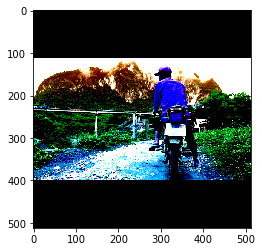

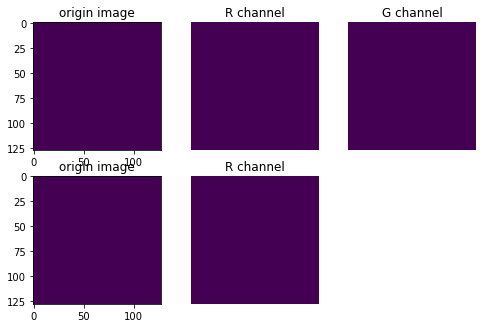

In [32]:
import matplotlib.pyplot as plt
plt.imshow(image_name)
plt.show()
cls = 4
plt.figure(num='astronaut',figsize=(8,8))  #创建一个名为astronaut的窗口,并设置大小 

plt.subplot(3,3,1)     #将窗口分为两行两列四个子图，则可显示四幅图片
plt.title('origin image')   #第一幅图片标题
plt.imshow(gridsample['hm'][5*cls])     #绘制第一幅图片

plt.subplot(3,3,2)     #第二个子图
plt.title('R channel')   #第二幅图片标题
plt.imshow(gridsample['hm'][5*cls+1])     #绘制第二幅图片,且为灰度图
plt.axis('off')     #不显示坐标尺寸

plt.subplot(3,3,3)     #第三个子图
plt.title('G channel')   #第三幅图片标题
plt.imshow(gridsample['hm'][5*cls++2])      #绘制第三幅图片,且为灰度图
plt.axis('off')     #不显示坐标尺寸

plt.subplot(3,3,4)     #将窗口分为两行两列四个子图，则可显示四幅图片
plt.title('origin image')   #第一幅图片标题
plt.imshow(gridsample['hm'][5*cls+3])      #绘制第一幅图片

plt.subplot(3,3,5)     #第二个子图
plt.title('R channel')   #第二幅图片标题
plt.imshow(gridsample['hm'][5*cls+4])      #绘制第二幅图片,且为灰度图
plt.axis('off')     #不显示坐标尺寸



plt.show()   #显示窗口

> <ipython-input-5-42926de01dcc>(83)run()
-> load_time, pre_time, net_time, dec_time, post_time = 0, 0, 0, 0, 0


(Pdb)  n


> <ipython-input-5-42926de01dcc>(84)run()
-> merge_time, tot_time = 0, 0


(Pdb)  n


> <ipython-input-5-42926de01dcc>(85)run()
-> image_name = None


(Pdb)  n


> <ipython-input-5-42926de01dcc>(86)run()
-> debugger = Debugger(dataset=self.opt.dataset, ipynb=(self.opt.debug==3),


(Pdb)  n


> <ipython-input-5-42926de01dcc>(87)run()
-> theme=self.opt.debugger_theme)


(Pdb)  n


> <ipython-input-5-42926de01dcc>(88)run()
-> start_time = time.time()


(Pdb)  n


> <ipython-input-5-42926de01dcc>(89)run()
-> pre_processed = False


(Pdb)  n


> <ipython-input-5-42926de01dcc>(90)run()
-> if isinstance(image_or_path_or_tensor, np.ndarray):


(Pdb)  n


> <ipython-input-5-42926de01dcc>(91)run()
-> image = image_or_path_or_tensor


(Pdb)  n


> <ipython-input-5-42926de01dcc>(101)run()
-> loaded_time = time.time()


(Pdb)  import matplotlib.pyplot as plt
(Pdb)  plt.imshow(image)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(Pdb)  plt.show()


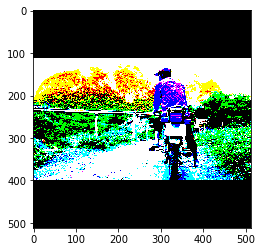

(Pdb)  n


> <ipython-input-5-42926de01dcc>(102)run()
-> load_time += (loaded_time - start_time)


(Pdb)  n


> <ipython-input-5-42926de01dcc>(104)run()
-> detections = []


(Pdb)  n


> <ipython-input-5-42926de01dcc>(105)run()
-> for scale in self.scales:


(Pdb)  n


> <ipython-input-5-42926de01dcc>(106)run()
-> scale_start_time = time.time()


(Pdb)  n


> <ipython-input-5-42926de01dcc>(107)run()
-> if not pre_processed:


(Pdb)  n


> <ipython-input-5-42926de01dcc>(108)run()
-> images, meta = self.pre_process(image, scale, meta)


(Pdb)  n


> <ipython-input-5-42926de01dcc>(114)run()
-> images = images.to(self.opt.device)


(Pdb)  images.shape


torch.Size([1, 3, 512, 512])


(Pdb)  plt.imshow(images.squeeze(0).permute(1,2,0))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(Pdb)  plt.show()


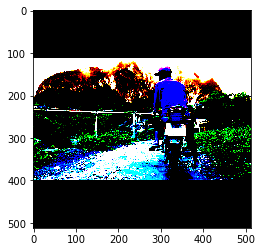

(Pdb)  n


> <ipython-input-5-42926de01dcc>(115)run()
-> torch.cuda.synchronize()


(Pdb)  n


> <ipython-input-5-42926de01dcc>(116)run()
-> pre_process_time = time.time()


(Pdb)  n


> <ipython-input-5-42926de01dcc>(117)run()
-> pre_time += pre_process_time - scale_start_time


(Pdb)  n


> <ipython-input-5-42926de01dcc>(119)run()
-> output, dets, forward_time = self.process(images, return_time=True)


(Pdb)  s


--Call--
> <ipython-input-11-5167bb3a526c>(5)process()
-> def process(self, images, return_time=False):


(Pdb)  n


> <ipython-input-11-5167bb3a526c>(6)process()
-> with torch.no_grad():


(Pdb)  n


> <ipython-input-11-5167bb3a526c>(7)process()
-> output = self.model(images)[-1]


(Pdb)  n


/home/mry/anaconda3/envs/centerpoint/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


> <ipython-input-11-5167bb3a526c>(8)process()
-> hm = output['hm'].sigmoid_()


(Pdb)  n


> <ipython-input-11-5167bb3a526c>(9)process()
-> wh = output['wh']


(Pdb)  hmm = h.clone().cpu().squeeze(0)


*** NameError: name 'h' is not defined


(Pdb)  hmm = hm.clone().cpu().squeeze(0)
(Pdb)  import matplotlib.pyplot as plt
(Pdb)  plt.imshow(hmm[0])


(Pdb)  plt.show()


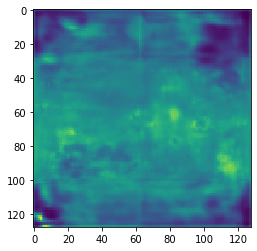

(Pdb)  plt.imshow(hmm[1])


(Pdb)  plt.show


<function show at 0x7f0864838ae8>


(Pdb)  plt.show()


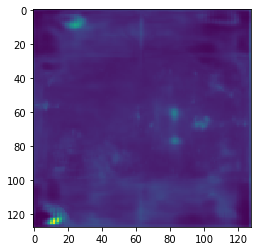

(Pdb)  plt.imshow(hmm[2])


(Pdb)  plt.show()


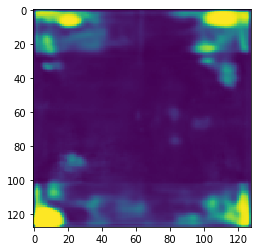

(Pdb)  plt.imshow(hmm[4])


(Pdb)  plt.show()


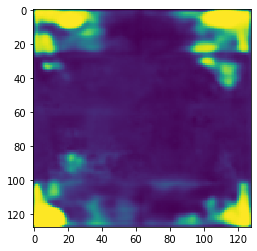

(Pdb)  plt.imshow(hmm[10])


(Pdb)  plt.show()


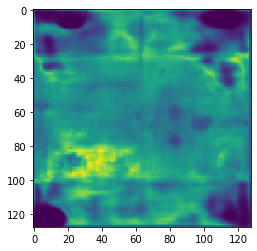

(Pdb)  q


BdbQuit: 

In [16]:
ret = Detector.run(image_name)

In [ ]:
plt.imshow(hmm[6])
plt.show()

In [ ]:
default='0,1,2,7,8'
